# Titles' generation of job vacancies (RNN-LSTM)

I started this project out of an idea for my master thesis in which I planned to examine the influence of Covid-19 at the job market in Germany.  But later I decided to change the topic of my master thesis. At this point I have already scraped about 40 thousand online job offers from one of the largest online job platforms in Germany – Stepstone. The data was scraped from its public website. The dataset consists of 12 columns. All rows consist of text information with two exceptions an id column and time column. The data is saved as json format. 
As a result, I decided to use this data set to develop my coding abilities in Python and my ML knowledge.  The task I decided to fulfil was the generation of job titles based on previous knowledge, namely: the X-features are job descriptions and job profiles, and the Y-feature are job titles. For this task I decided to develop RNN-LSTM model.
The knowledge I gained with this project:
1.	Extracting the data from website using the scrapy framework.
2.	Intensive cleaning of the data using regex. For example, in some cases the German letter “ü” was scrapped as two symbols instead of one letter. Generally speaking, original job offers contain different symbols that are not useful or necessary for the development of NLP applications.
In Germany it is prescribed by law to mention in job offers that they are available to people with different/all genders. The problem is that these formulations are not standardized. This means that different firms use different combinations to show gender-inclusivity. Looking for all possible combinations was a very complex and time intensive task.
3.	I found out that some job offers are not in the German language. I cleaned my data set and left only job offers that are written in German. 
4.	In my data set there only 385 data science offers.
5.	For the NLP application I started with lemmatization. The most interesting part of this was to find out that multiprocessing in Python on Windows in Jupyter is problematic. Windows doesn’t support thread forking as a result child process can’t be distinguished from parent process. After internet research how to solve this problem, I found out that the best solution is to create a separate file and then to use multiple processor cores to execute the function in this file in parallel. 
6. The next step was to develop a word embedding. I used the Word2Vec and I developed 3 models using it. This step is necessary for my future RNN-LSTM model. 
Word2Vec is a two-layer NN that processes words and vectorizing them. This method, from mathematical point of view, is looking for similarities between words. Because we obtain vectors from words it is then possible to calculate the cosine similarity in n-dimension. Let imagine that we have x and y vectors. To calculate sim(x,y) we need to calculate the Euclidean norm of vector x and vector y. We also need to calculate a dot product of x and y, too. For example ([3,8], [10,8]). 
sum(x * y) / (sqrt(sum(x^2)) * sqrt(sum(y^2))) = sum(3*10 + 8*8) / (sqrt(sum(3^2 + 8^2)) * sqrt(sum(10^2 + 8^2))) = 0.86. As we know 1 is perfectly similar, we have 0.86.
I would like to mention that I optimized my model. Parameter negative sampling brought a little improvement of my model’s performance. Negative sampling converts multi-classification task into binary-classification task. The goal is to identify if the word is positive = 1 or negative = 0. As a result, we have a binary task and instead of using a softmax to compute a probability distribution of observing an output word given an input word the model uses sigmoid function to learn to differentiate the actual context words/positive word from randomly drawn words/negative. (The explanation that was very helpful: https://aegis4048.github.io/optimize_computational_efficiency_of_skip-gram_with_negative_sampling). 
7. Model creation: First, we need to tokenize texts and then sequence them. Texts are returned into sequence of integers. Long Short Term Memory networks are a special kind of RNN. It is designed to avoid the long-term dependency problem. The structure of LSTM is like a chain. General information and details about RNN-LSTM are available: https://colah.github.io/posts/2015-08-Understanding-LSTMs/. 
This type of networks generally used for NLP text generation. The input vectors represent each word in a sequence using lookups in a word embedding matrix. We also need to do a one hot encoded vector representation. In my model I also use the weights from my Word2Vec model. 
The model flow is the following: Embeddings are passed through a single LSTM layer. Then they passed into a fully connected layer with a relu activation. And then they reach the final output layer with a softmax activation. The final layer produces a probability for every word in the vocabulary. To calculate the loss function, I used categorical_crossentropy. An adam optimizer is used to update the weights with gradients calculated through backpropagation.
At this step I ran into problems, for example the latest stable version of tensorflow does not work together with the last version of panda. As a result, I had to downgrade the Panda library. The plan was to compare Random Search and Grid Search for function optimization. To fulfil this plan, I wanted to use GPU acceleration. But tensorflow didn’t recognize my GPU. Internet research recommended me to solve this problem by reinstalling my tensorflow with pip and installing tensorflow-gpu with conda. Potentially I would need then to create a new conda environment, etc. The lack of time prevented me to start this process.

## Further optimization
At the end my model had a poor performance. The following steps could potentially improve the performance of the model: 
-	change the training length because I only used 70 words
-	instead of Word2Vec (with own embeddings) one could use pre-trained embeddings e.g., BERT or Glove 
-	try different parameters of the network
-	change the model. I have found out that potentially for this tasks CNNs could have a better performance (https://arxiv.org/abs/1503.05034).

## Appendix:
1.	Top2Vec. “Top2Vec is an algorithm for topic modeling and semantic search. It automatically detects topics present in text and generates jointly embedded topic, document and word vectors” (https://github.com/ddangelov/Top2Vec). This module is easy to use and the results are pretty good. 
2.	Word frequency and TF-IDF.
3.	K-means clustering. I used the elbow method and silhouette score to find an optimal k. Silhouette score showed a better result. But the results are still pretty poor. The next time I would start from hierarchical clustering.
4.	Finally, FlairNLP is an equivalent library based on the PyTorch framework. It was easy and intuitive to use an GPU for calculations. The tutorials by creators of the library are very helpful. But, CUDA was out of memory during my first try. Potentially we could solve this problem this way: https://github.com/flairNLP/flair/issues/508


In [1]:
import json


In [2]:
import matplotlib.pyplot as plt
#import seaborn as sns
# Assess sentiment classification models 
#from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Importing standard packages. 
import pandas as pd
import numpy as np
import seaborn as sns

# Library re provides regular expressions functionality
import re

# To keep an eye on runtimes
import time

# Saving and loaded objects
import pickle

# langage detection
from langdetect import detect

# Standard NLP workflow
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import sent_tokenize

In [4]:
data = []
with open('../data/jobs.json', encoding='utf-8') as file:
    data = json.load(file)

In [5]:
df = pd.DataFrame(data) #transforming json dictionary arrays into DataFrame

In [6]:
# Changing object type column to datetime
df['time'] = pd.to_datetime(df.time)

# Creating new column with just the date
df['date'] = df['time'].dt.date

In [9]:
df.head()

id                time  \
0  7216535 2021-06-05 11:21:09   
1  7216528 2021-06-05 11:21:09   
2  7209677 2021-06-05 11:21:09   
3  7034977 2021-06-05 11:21:09   
4  7238797 2021-06-05 11:21:09   

                                               title  \
0  Haushaltshilfe / Housekeeping (m/w/d) für Conc...   
1  Teamleiter (m/w/d) für unsere Triebfahrzeugfüh...   
2  Sales / Pre-Sales Spezialist (m/w/d) für Studi...   
3  IT-Fachkraft / IT-Spezialist als IT-Administra...   
4  Pflegekraft in der Pflegeeinrichtung auf Pellw...   

                               company    location     contract_type  \
0            ACG Alster Concierge GmbH     Hamburg  Feste Anstellung   
1         Railtrans International, a.s  bundesweit  Feste Anstellung   
2                            TELTEC AG     München  Feste Anstellung   
3   Boyens Medienholding GmbH & Co. KG       Heide  Feste Anstellung   
4  DRK Kreisverband Nordfriesland e.V.       Husum  Feste Anstellung   

            work_type                                       introduction  \
0            Teilzeit  <p>Der moderne Alltag ist ein komplexes Zusamm...   
1            Vollzeit  <p><strong>Teamleiter (m/w/d) für unsere Trieb...   
2            Vollzeit  <p>Die <strong>Teltec AG</strong> ist seit meh...   
3            Vollzeit  <p><strong>Arbeiten in einem modernen Medienun...   
4  Vollzeit, Teilzeit  <p>Der DRK-Kreisverband Nordfriesland e.V. in ...   

                                     job_description  \
0  <div class="at-section-text-description-conten...   
1  <div class="at-section-text-description-conten...   
2  <div class="at-section-text-description-conten...   
3  <div class="at-section-text-description-conten...   
4  <div class="at-section-text-description-conten...   

                                             profile  \
0  <div class="at-section-text-profile-content sc...   
1  <div class="at-section-text-profile-content sc...   
2  <div class="at-section-text-profile-content sc...   
3  <div class="at-section-text-profile-content sc...   
4  <div class="at-section-text-profile-content sc...   

                                            we_offer  \
0  <div class="at-section-text-weoffer-content sc...   
1  <div class="at-section-text-weoffer-content sc...   
2  <div class="at-section-text-weoffer-content sc...   
3  <div class="at-section-text-weoffer-content sc...   
4  <div class="at-section-text-weoffer-content sc...   

                                            contacts        date  
0  <div class="at-section-text-contact-content sc...  2021-06-05  
1  <div class="at-section-text-contact-content sc...  2021-06-05  
2  <div class="at-section-text-contact-content sc...  2021-06-05  
3  <div class="at-section-text-contact-content sc...  2021-06-05  
4  <div class="at-section-text-contact-content sc...  2021-06-05

The next step is examing the data quality and namly the amount of not available data/missing data in the dataset. And to be sure that the scraping was done correctlly I check also if  dunplicates exist based on the unique id.  

In [9]:
#NAs 
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total   Percent
introduction      7567  0.186223
contacts          4438  0.109219
we_offer          3818  0.093961
contract_type     2891  0.071147
work_type         2885  0.071000
profile           1386  0.034109
job_description   1132  0.027858
company              4  0.000098
location             4  0.000098
title                1  0.000025
id                   0  0.000000
time                 0  0.000000

In [10]:
df[df.duplicated(['id'], keep=False)] #check in if there are any duplicates

Empty DataFrame
Columns: [id, time, title, company, location, contract_type, work_type, introduction, job_description, profile, we_offer, contacts]
Index: []

As we can see there are no duplicates and generally speaking the amount of missing values is not very big. The largest amount of NAs present in the "introduction" column. Generally, in this section companies describe themselves. In the solumn we_offer companies decribe the benefits that candidat can have if gets this job. I made the decision to fill NAs with empty strings.

In [7]:
#The amount of NAs is very small. Text featurures consist NAs, as a result I ldecided to leav them 
df["introduction"].fillna("", inplace = True)
df["we_offer"].fillna("", inplace = True)
df["contacts"].fillna("", inplace = True)
df["profile"].fillna("", inplace = True)
df["job_description"].fillna("", inplace = True)
df["work_type"].fillna("", inplace = True)
df["company"].fillna("", inplace = True)
df["contract_type"].fillna("", inplace = True)
df["location"].fillna("", inplace = True)
df["title"].fillna("", inplace = True)

In [9]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
id                   0      0.0
time                 0      0.0
title                0      0.0
company              0      0.0
location             0      0.0
contract_type        0      0.0
work_type            0      0.0
introduction         0      0.0
job_description      0      0.0
profile              0      0.0
we_offer             0      0.0
contacts             0      0.0
date                 0      0.0

Graffic visualisation

Text(0.5, 1.0, 'Location')

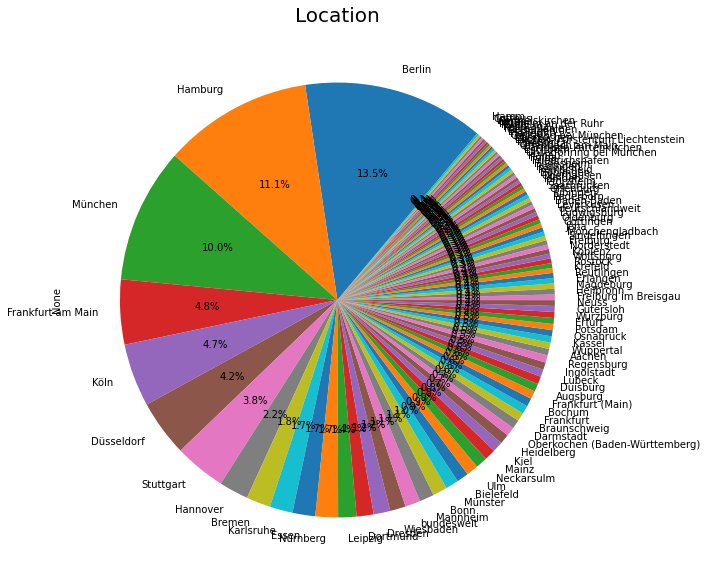

In [18]:
df.location.apply(pd.Series).stack().str.strip().value_counts()[:100].plot.pie(figsize=(12,10), startangle=50, autopct='%1.1f%%', fontsize=10)
plt.title("Location",fontsize=20)

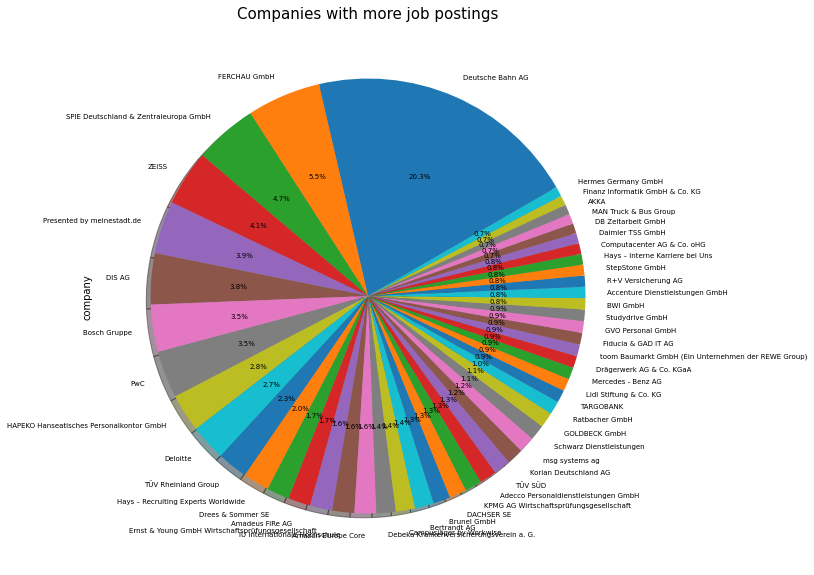

In [16]:
df["company"].value_counts()[:50].plot.pie(figsize=(12,10), shadow=True, startangle=30, autopct='%1.1f%%', fontsize=7)
plt.title("Companies with more job postings", fontsize=15)
plt.show()

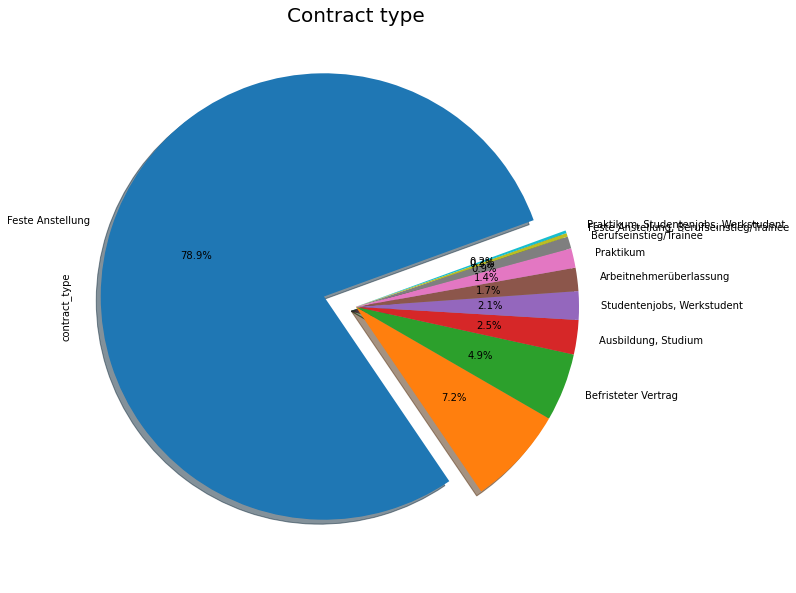

In [77]:
explodeTuple = (0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
df["contract_type"].value_counts()[:10].plot.pie(figsize=(10,15), shadow=True, startangle=20, autopct='%1.1f%%', explode=explodeTuple, fontsize=10)
plt.title("Contract type", fontsize=20)
plt.show()

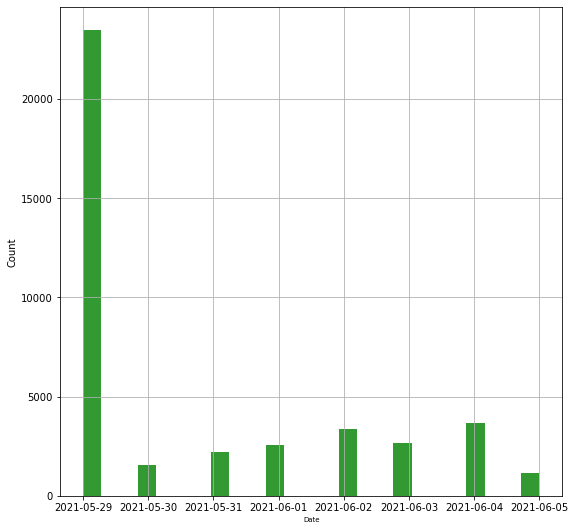

In [76]:
plt.figure(figsize=(9,9))
n, bins, patches = plt.hist(df['date'], 25, facecolor='g', alpha=0.8)
plt.xlabel('Date', size = 7)
plt.ylabel('Count')
#plt.title('XY', size = 7)
plt.xticks(size = 10)
plt.grid(True)
#plt.show()

### Data cleaning

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40634 entries, 0 to 40633
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               40634 non-null  object        
 1   time             40634 non-null  datetime64[ns]
 2   title            40634 non-null  object        
 3   company          40634 non-null  object        
 4   location         40634 non-null  object        
 5   contract_type    40634 non-null  object        
 6   work_type        40634 non-null  object        
 7   introduction     40634 non-null  object        
 8   job_description  40634 non-null  object        
 9   profile          40634 non-null  object        
 10  we_offer         40634 non-null  object        
 11  contacts         40634 non-null  object        
 12  date             40634 non-null  object        
dtypes: datetime64[ns](1), object(12)
memory usage: 4.0+ MB


In [79]:
df.introduction.head()

0    <p>Der moderne Alltag ist ein komplexes Zusamm...
1    <p><strong>Teamleiter (m/w/d) für unsere Trieb...
2    <p>Die <strong>Teltec AG</strong> ist seit meh...
3    <p><strong>Arbeiten in einem modernen Medienun...
4    <p>Der DRK-Kreisverband Nordfriesland e.V. in ...
Name: introduction, dtype: object

# Cleaning regex 
I have found out that in column "title" a lot of differnt symbols exist that do not have any symantic or contextual value. I suppose that they are also present in other text colums. The best way to deal with them is to find and replace, if necessary, or to remove.   

In [192]:
df[df['title'].str.contains('[^a-zA-Z0-9àâéöäüßÖÄÜÀ/ )(*\-–_—‐.:;,®°=•>>\n&€+|*+!#%–§@`³²?¤\" ”\» «\>> <<\xa0\"\´\\u200b\\t\\xad\u2008\ufeff\u202f\u2009/„“\‚‘\[\]]')].title

428      Key Account Manager Immobilienpartner f�r die ...
1772     Assistenz der Geschäftsführung (m/w/d) – Tei...
1943     Referentin bzw. Referent (w/m/d) für Veränder...
2382                      Akquisiteur (m/w/d) Grundstücke
3115     Beschäftigter im Bereich Projektentwicklung /...
4724     Referent (m/w/d) in der Albertinen Diakoniewer...
5578     Bankkaufmann/Baufinanzierungsberater B2C G�ppi...
10871    Heizung, Lüftung, Klima Projektingenieurin / ...
10980    Rechtsanwalt (m/w/d) für gewerblichen Rechtss...
11411    Sachbearbeiter (m/w/d) für die Gebührenüber...
11475    Account Manager für technische Einkäufer / So...
13315    Sachbearbeiterin / Sachbearbeiter (m/w/d) für...
13584           Presales Berater (m·w·d) für Ladestationen
13586       Sales Manager (m·w·d) Vertrieb E-Ladestationen
13588    Partner Manager (m·w·d) für Vertriebspartnersc...
15900    Ausbildung zum Fachinformatiker f�r Anwendungs...
16239    Ausbildung zum Kaufmann f�r Dialogmarketing (m.

In [188]:
re.search('[^a-zA-Z0-9öäüß/ )(*\-–.:,+•\" ”\n&\xa0\'̈]', 'Pﬂegefachkraft für die Phase F (m/w/d)')

<re.Match object; span=(1, 2), match='ﬂ'>

In [203]:
df['title'][2382]

'Akquisiteur (m/w/d) Grundstücke'

In [8]:
df[df['title'].str.contains('\\u2009')].title[2147]

'Entwicklungs-\u2009/\u2009Systemingenieur (m/w/x) im Bereich Regelungstechnik'

In [9]:
df[df['title'].str.contains(' f ')].title

1389     Product Specialist (m / f / d), Regional Proje...
1848     Product Specialist CV (m / f / d), Sales (Clin...
1870     Product Specialist, Oncology (m / f / d) - Sal...
1903     Product Specialist (m / f / d), Sales CV - Are...
21755               Regulatory Affairs Manager (m / f / d)
26166                            Project Analyst m | f | d
30246    Expert Process Engineering Focus Extrusion (m ...
Name: title, dtype: object

'̈ � ﬂ à â é symbols to replace


In [8]:
import re

def clean_text(raw_html):
    clean_ae = re.compile('ä')
    clean_a = re.compile('à|â')  
    clean_e = re.compile('é')
    clean_ue = re.compile('ü|�')
    clean_A = re.compile ('À')
    clean_zeichen = re.compile('[^a-zA-Z0-9öäüß.]|\\xa0|\\u200b|\\t|\\xad|\\\xadd|\\u2008|\\ufeff|\\u202f|\\u2009]') 
    clean_html = re.compile('<.*?>')
    clean_n = re.compile('\\n')
    clean_s = re.compile('\s\s+')
    gn = re.compile('\sgn\s')
    star_innen = re.compile('\sinnen\s')
    gendering = re.compile('\([mdwfwx]?[·|/]?[mdwfwx]?[·|/]?([mdwfwxia*d]|gn)?\)', flags=re.IGNORECASE)#(w|m|d)(m·w·d)(m/w/d) 
    gendering2 = re.compile('\sm\s*w\s*d(iv)?')
    einzelne_buchstaben = re.compile('\s[a-zA-Z0-9öäüß]\s')
    cleantext = re.sub(clean_ae, 'ä', raw_html)
    cleantext = re.sub(clean_a, 'a', cleantext)
    cleantext = re.sub(clean_e, 'e', cleantext)
    cleantext = re.sub(clean_ue, 'ü', cleantext)
    cleantext = re.sub(clean_A, 'A', cleantext)
    cleantext = re.sub(clean_html, ' ', cleantext)
    cleantext = re.sub(clean_n, ' ', cleantext)
    cleantext = re.sub(gn, ' ', cleantext)
    cleantext = re.sub(gendering, ' ', cleantext)
    cleantext = re.sub(clean_zeichen, ' ', cleantext)
    cleantext = re.sub(clean_s, ' ', cleantext)
    cleantext = re.sub(gendering2, ' ', cleantext)
    cleantext = re.sub(star_innen, ' ', cleantext)
    cleantext = re.sub(einzelne_buchstaben, ' ', cleantext)
    cleantext = re.sub(einzelne_buchstaben, ' ', cleantext)
    cleantext = re.sub(clean_s, ' ', cleantext)
    
    return cleantext.strip()

In [9]:
df['clean_introduction'] = df['introduction'].apply(clean_text)
df['clean_job_description'] = df['job_description'].apply(clean_text)
df['clean_profile'] = df['profile'].apply(clean_text)
df['clean_we_offer'] = df['we_offer'].apply(clean_text)
df['clean_contacts'] = df['contacts'].apply(clean_text)
df['clean_title'] = df['title'].apply(clean_text)

In [85]:
df.clean_job_description[1]

' Wir suchen einen erfahrenen Triebfahrzeugführer, der ca. 50 % seiner Arbeitszeit als fachlicher und organisatorischer Ansprechpartner für unser Betriebspersonal fungieren wird. Der zweite Baustein seiner Tätigkeit ist sein Einsatz als Tf für Güterfernzüge im Spot- und Regelverkehr bundesweit in Deutschland und auch grenzüberschreitend bzw. in Grenzbahnhöfe. Seine Aufgaben: Einhaltung und Beachtung der Vorgaben aus dem Sicherheitsmanagementsystem Fachliche und organisatorische Teamleitung des Betriebspersonals Mitarbeit bei der Weiterentwicklung des Sicherheitsmanagementsystems Durchführung der Überwachung bei internem und externen Betriebspersonal Vorbereitende Tätigkeiten zur Entgeltabrechnung des Betriebspersonals Vorbereitung und Durchführung von Zug- und Rangierfahrten im Güterfernverkehr auf den Strecken der DB Netz AG und zu/von Grenz- und Übergangsbahnhöfen Sicherstellung des sicheren, pünktlichen, wirtschaftlichen sowie kundenorientierten Fahrbetriebs Kommunikation mit intern

In [86]:
df.clean_introduction.head()

0     Der moderne Alltag ist ein komplexes Zusammen...
1     Teamleiter für unsere Triebfahrzeugführer im ...
2     Die Teltec AG ist seit mehr als 25 Jahren der...
3     Arbeiten in einem modernen Medienunternehmen ...
4     Der DRK-Kreisverband Nordfriesland e.V. in Hu...
Name: clean_introduction, dtype: object

In [10]:
df.drop(['we_offer', 'contacts'], inplace=True, axis=1)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40634 entries, 0 to 40633
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     40634 non-null  object
 1   title                  40634 non-null  object
 2   company                40634 non-null  object
 3   location               40634 non-null  object
 4   contract_type          40634 non-null  object
 5   work_type              40634 non-null  object
 6   introduction           40634 non-null  object
 7   job_description        40634 non-null  object
 8   profile                40634 non-null  object
 9   date                   40634 non-null  object
 10  clean_introduction     40634 non-null  object
 11  clean_job_description  40634 non-null  object
 12  clean_profile          40634 non-null  object
 13  clean_we_offer         40634 non-null  object
 14  clean_contacts         40634 non-null  object
 15  clean_title        

## Language detection

In [20]:
df['language'] = df["clean_introduction"].apply(lambda x: detect(x) if 
                                 x.strip() != "" else "")
df.head()

id                                              title  \
0  7216535  Haushaltshilfe / Housekeeping (m/w/d) für Conc...   
1  7216528  Teamleiter (m/w/d) für unsere Triebfahrzeugfüh...   
2  7209677  Sales / Pre-Sales Spezialist (m/w/d) für Studi...   
3  7034977  IT-Fachkraft / IT-Spezialist als IT-Administra...   
4  7238797  Pflegekraft in der Pflegeeinrichtung auf Pellw...   

                               company    location     contract_type  \
0            ACG Alster Concierge GmbH     Hamburg  Feste Anstellung   
1         Railtrans International, a.s  bundesweit  Feste Anstellung   
2                            TELTEC AG     München  Feste Anstellung   
3   Boyens Medienholding GmbH & Co. KG       Heide  Feste Anstellung   
4  DRK Kreisverband Nordfriesland e.V.       Husum  Feste Anstellung   

            work_type                                       introduction  \
0            Teilzeit  <p>Der moderne Alltag ist ein komplexes Zusamm...   
1            Vollzeit  <p><strong>Teamleiter (m/w/d) für unsere Trieb...   
2            Vollzeit  <p>Die <strong>Teltec AG</strong> ist seit meh...   
3            Vollzeit  <p><strong>Arbeiten in einem modernen Medienun...   
4  Vollzeit, Teilzeit  <p>Der DRK-Kreisverband Nordfriesland e.V. in ...   

                                     job_description  \
0  <div class="at-section-text-description-conten...   
1  <div class="at-section-text-description-conten...   
2  <div class="at-section-text-description-conten...   
3  <div class="at-section-text-description-conten...   
4  <div class="at-section-text-description-conten...   

                                             profile        date  \
0  <div class="at-section-text-profile-content sc...  2021-06-05   
1  <div class="at-section-text-profile-content sc...  2021-06-05   
2  <div class="at-section-text-profile-content sc...  2021-06-05   
3  <div class="at-section-text-profile-content sc...  2021-06-05   
4  <div class="at-section-text-profile-content sc...  2021-06-05   

                                  clean_introduction  \
0  Der moderne Alltag ist ein komplexes Zusammens...   
1  Teamleiter für unsere Triebfahrzeugführer im G...   
2  Die Teltec AG ist seit mehr als 25 Jahren der ...   
3  Arbeiten in einem modernen Medienunternehmen d...   
4  Der DRK Kreisverband Nordfriesland e V in Husu...   

                               clean_job_description  \
0  Botengänge fahrten und Erledigung von Einkäufe...   
1  Wir suchen einen erfahrenen Triebfahrzeugführe...   
2  Sie betreuen engagiert unsere nationalen und i...   
3  Helpdesk Benutzerunterstützung Administration ...   
4  Professionelle ganzheitliche und individuelle ...   

                                       clean_profile  \
0  Sehr gute Deutschkenntnisse sowie gute Englisc...   
1  Der ideale Bewerber verfügt über erfolgreich a...   
2  Abgeschlossene Ausbildung zum Mediengestalter ...   
3  Abgeschlossene Ausbildung oder Studium im IT B...   
4  Sie haben eine dreijährige Ausbildung im Berei...   

                                      clean_we_offer  \
0  Sozialversicherungspflichtiges Angestelltenver...   
1  überdurchschnittliches Gehalt attraktive Nacht...   
2  Ein kollegiales motiviertes dynamisches und he...   
3  Interessantes vielseitiges und zukunftssichere...   
4  ein freundliches Betriebsklima mit einem motiv...   

                                      clean_contacts  \
0  Für Rückfragen steht Ihnen die Geschäftsführer...   
1  Weitere Details erfahren Sie gerne im persönli...   
2  Wir freuen uns auf Ihre Bewerbung vorzugsweise...   
3  Ihre Bewerbung mit aussagekräftigen Unterlagen...   
4  Haben Sie Interesse Dann freuen wir uns über I...   

                                         clean_title language  
0  Haushaltshilfe Housekeeping für Concierge Serv...       de  
1  Teamleiter für unsere Triebfahrzeugführer im G...       de  
2  Sales Pre Sales Spezialist für Studio und Prod...       de  
3    IT Fachkraft IT Spezialist als IT A

Text(0.5, 1.0, 'language')

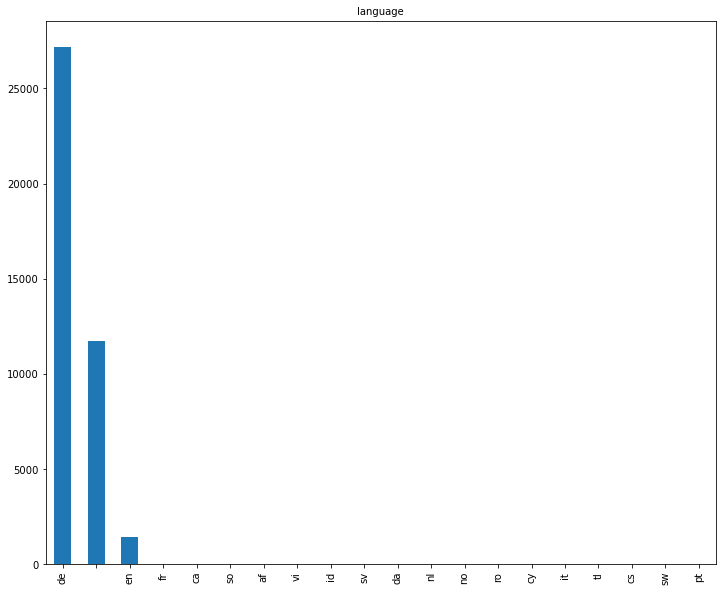

In [232]:
plot_data = df.language.apply(pd.Series).stack().str.strip().value_counts()[:20]
plot_data.plot.bar(figsize=(12,10), fontsize=10)
plt.title("language",fontsize=10)

In [92]:
df[df['language']!='de']

id                                              title  \
9      7211025                       Full Stack Architect (m/f/d)   
18     7130533                        Software Entwickler (m/w/d)   
19     7130522  Software Test Manager / Testkoordinator (m/w/d...   
36     7131796               Influencer Relations Manager (m/w/d)   
74     7178354  Studienkoordinator / Studienassistenz für Medi...   
...        ...                                                ...   
40621  7121685                      Senior Accountant (m/w/d) HGB   
40623  7234005  Praktikant (m/w/d) Category Management Support...   
40624  7234234                        Empfangsmitarbeiter (m/w/d)   
40631  7199652                   Junior Operation Manager (m/w/d)   
40633  7201275           Rettungsschwimmer (m/w/d) zum 01.06.2021   

                                                 company  \
9                                Noyes Technologies GmbH   
18                                 Pico Engineering GmbH   
19                                 Pico Engineering GmbH   
36                                  ghd Deutschland GmbH   
74                    CardioVasculäres Centrum Frankfurt   
...                                                  ...   
40621                                       EQS Group AG   
40623                                         REWE Group   
40624                 Hotel Ascari GmbH Ascari Parkhotel   
40631                                   Baltic Hideaways   
40633  Center Parcs Bungalowpark Bispingen GmbH Cente...   

                                location     contract_type  \
9                                München  Feste Anstellung   
18                              Hannover  Feste Anstellung   
19     Berlin, Hannover oder Home Office  Feste Anstellung   
36                             Stuttgart  Feste Anstellung   
74                             Frankfurt  Feste Anstellung   
...                                  ...               ...   
40621                            München  Feste Anstellung   
40623                               Köln         Praktikum   
40624                            Pulheim                     
40631                               Binz                     
40633                          Bispingen                     

                   work_type  \
9                   Vollzeit   
18                  Vollzeit   
19     Vollzeit, Home Office   
36                  Vollzeit   
74        Vollzeit, Teilzeit   
...                      ...   
40621               Vollzeit   
40623               Vollzeit   
40624                          
40631                          
40633                          

                                            introduction  \
9      <p>We are Noyes Technologies, a Munich-based t...   
18         <p><strong>pico engineering GmbH</strong></p>   
19         <p><strong>pico engineering GmbH</strong></p>   
36     <p>ghd Deutschland GmbH, based in Stuttgart, G...   
74                                               <p></p>   
...                                                  ...   
40621  <p>EQS Group is a leading international provid...   
40623                                                      
40624                                            <p></p>   
40631                                            <p></p>   
40633                                            <p></p>   

                                         job_description  \
9      <div class="at-section-text-description-conten...   
18     <div class="at-section-text-description-conten...   
19     <div class="at-section-text-description-conten...   
36     <div class="at-section-text-description-conten...   
74     <div class="at-section-text-description-conten...   
...                                                  ...   
40621  <div class="at-section-text-description-conten...   
40623                                                      
40624  <div class="at-section-text-description-conten...   
40631  <div

In [ ]:
#df['language_clean_title'] = df["clean_title"].apply(lambda x: detect(x) if 
#                                 x.strip() != "" else "")
#df.head()

In [ ]:
#plot_data_title = df.language_clean_title.apply(pd.Series).stack().str.strip().value_counts()[:20]
#plot_data_title.plot.bar(figsize=(12,10), fontsize=10)
#plt.title("language_clean_title",fontsize=20)

By discovering the languages that are used in column “clean_job_description” an error occured: "No features in text". Because of the data’s amount the most convenient way to deal with this problem is to detect the rows that causes an error.

In [233]:
df["clean_job_description"].head(5)

0     Botengänge fahrten und Erledigung von Einkäuf...
1     Wir suchen einen erfahrenen Triebfahrzeugführ...
2     Sie betreuen engagiert unsere nationalen und ...
3     Helpdesk Benutzerunterstützung Administration...
4     Professionelle ganzheitliche und individuelle...
Name: clean_job_description, dtype: object

In [18]:
for row in df["clean_job_description"]:
    try:
        language = detect(row) if row.strip() != "" else ""
    except:
        language = "error"
        print("This row throws and error:", row, len(row))
    #row.append(language)
    #all.append(row)

This row throws and error: . 1


In [19]:
df[df["clean_job_description"] == ' . ']

Empty DataFrame
Columns: [id, title, company, location, contract_type, work_type, introduction, job_description, profile, date, clean_introduction, clean_job_description, clean_profile, clean_we_offer, clean_contacts, clean_title]
Index: []

In [11]:
df = df.drop([20958])

In [12]:
df['language_job_description'] = df["clean_job_description"].apply(lambda x: detect(x) if x.strip() != "" else "")
df.head()

id                time  \
0  7216535 2021-06-05 11:21:09   
1  7216528 2021-06-05 11:21:09   
2  7209677 2021-06-05 11:21:09   
3  7034977 2021-06-05 11:21:09   
4  7238797 2021-06-05 11:21:09   

                                               title  \
0  Haushaltshilfe / Housekeeping (m/w/d) für Conc...   
1  Teamleiter (m/w/d) für unsere Triebfahrzeugfüh...   
2  Sales / Pre-Sales Spezialist (m/w/d) für Studi...   
3  IT-Fachkraft / IT-Spezialist als IT-Administra...   
4  Pflegekraft in der Pflegeeinrichtung auf Pellw...   

                               company    location     contract_type  \
0            ACG Alster Concierge GmbH     Hamburg  Feste Anstellung   
1         Railtrans International, a.s  bundesweit  Feste Anstellung   
2                            TELTEC AG     München  Feste Anstellung   
3   Boyens Medienholding GmbH & Co. KG       Heide  Feste Anstellung   
4  DRK Kreisverband Nordfriesland e.V.       Husum  Feste Anstellung   

            work_type                                       introduction  \
0            Teilzeit  <p>Der moderne Alltag ist ein komplexes Zusamm...   
1            Vollzeit  <p><strong>Teamleiter (m/w/d) für unsere Trieb...   
2            Vollzeit  <p>Die <strong>Teltec AG</strong> ist seit meh...   
3            Vollzeit  <p><strong>Arbeiten in einem modernen Medienun...   
4  Vollzeit, Teilzeit  <p>Der DRK-Kreisverband Nordfriesland e.V. in ...   

                                     job_description  \
0  <div class="at-section-text-description-conten...   
1  <div class="at-section-text-description-conten...   
2  <div class="at-section-text-description-conten...   
3  <div class="at-section-text-description-conten...   
4  <div class="at-section-text-description-conten...   

                                             profile        date  \
0  <div class="at-section-text-profile-content sc...  2021-06-05   
1  <div class="at-section-text-profile-content sc...  2021-06-05   
2  <div class="at-section-text-profile-content sc...  2021-06-05   
3  <div class="at-section-text-profile-content sc...  2021-06-05   
4  <div class="at-section-text-profile-content sc...  2021-06-05   

                                  clean_introduction  \
0  Der moderne Alltag ist ein komplexes Zusammens...   
1  Teamleiter für unsere Triebfahrzeugführer im G...   
2  Die Teltec AG ist seit mehr als 25 Jahren der ...   
3  Arbeiten in einem modernen Medienunternehmen d...   
4  Der DRK Kreisverband Nordfriesland e.V. in Hus...   

                               clean_job_description  \
0  Botengänge fahrten und Erledigung von Einkäufe...   
1  Wir suchen einen erfahrenen Triebfahrzeugführe...   
2  Sie betreuen engagiert unsere nationalen und i...   
3  Helpdesk Benutzerunterstützung Administration ...   
4  Professionelle ganzheitliche und individuelle ...   

                                       clean_profile  \
0  Sehr gute Deutschkenntnisse sowie gute Englisc...   
1  Der ideale Bewerber verfügt über erfolgreich a...   
2  Abgeschlossene Ausbildung zum Mediengestalter ...   
3  Abgeschlossene Ausbildung oder Studium im IT B...   
4  Sie haben eine dreijährige Ausbildung im Berei...   

                                      clean_we_offer  \
0  Sozialversicherungspflichtiges Angestelltenver...   
1  überdurchschnittliches Gehalt attraktive Nacht...   
2  Ein kollegiales motiviertes dynamisches und he...   
3  Interessantes vielseitiges und zukunftssichere...   
4  ein freundliches Betriebsklima mit einem motiv...   

                                      clean_contacts  \
0  Für Rückfragen steht Ihnen die Geschäftsführer...   
1  Weitere Details erfahren Sie gerne im persönli...   
2  Wir freuen uns auf Ihre Bewerbung vorzugsweise...   
3  Ihre Bewerbung mit aussagekräftigen Unterlagen...   
4  Haben Sie Interesse Dann freuen wir uns über I...   

                                         clean_title language_job_description  
0  Haushaltshilfe Housekeeping für Concierge Serv...             

Text(0.5, 1.0, 'language_job')

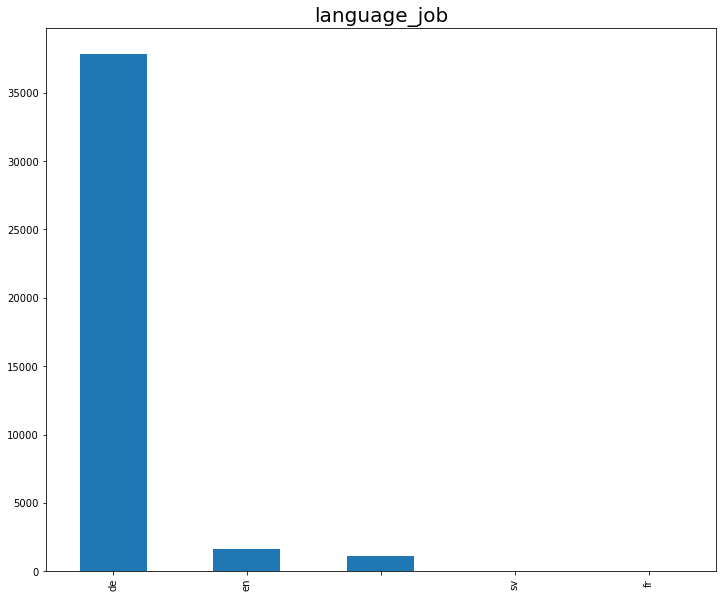

In [237]:
plot_data_job = df.language_job_description.apply(pd.Series).stack().str.strip().value_counts()[:20]
plot_data_job.plot.bar(figsize=(12,10), fontsize=10)
plt.title("language_job",fontsize=20)

In [13]:
df = df[df["language_job_description"] == "de"]
df.shape

(37859, 18)

In [14]:
df['language_job_description'].value_counts()

de    37859
Name: language_job_description, dtype: int64

## Length analysis

In [15]:
df['word_count'] = df["clean_job_description"].apply(lambda x: len(str(x).split(" ")))

In [14]:
df['word_count_profile'] = df["clean_profile"].apply(lambda x: len(str(x).split(" ")))

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_count_profile'>

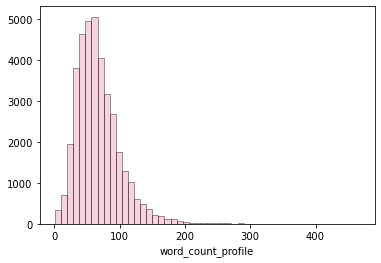

In [15]:
sns.distplot(df['word_count_profile'], hist=True, kde=False, color = '#ec95ac',
             hist_kws={'edgecolor':'black'})

C:\Users\bb1\miniconda3\envs\deep\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_count'>

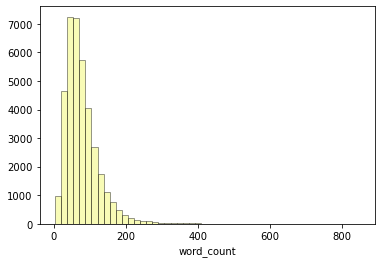

In [26]:
sns.distplot(df['word_count'], hist=True, kde=False, color = '#eff549',
             hist_kws={'edgecolor':'black'})

Text(0, 0.5, 'density')

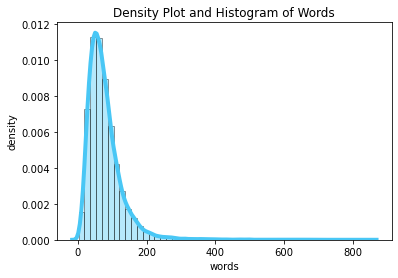

In [27]:
sns.distplot(df['word_count'], hist=True, kde=True, 
             color = '#49c7f5', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Density Plot and Histogram of Words') 
plt.xlabel('words'); plt.ylabel('density')

# Data Science Jobs

In [18]:
df[df['clean_title'].str.contains('Data')].clean_title

In [27]:
df[df['clean_title'].str.contains('Science')].clean_title

1007                         Data Engineer HR Data Science
2045     Duales Studium Duales Studium Bachelor of Engi...
2135     Customer Solutions Head Consulting Life Scienc...
2168                        Cloud Engineer AI Data Science
2479     Medizinisch technische Laboratoriumsassistenz ...
                               ...                        
37602    Biologisch oder Medizinisch Technischer Assist...
38831    Medical Science Liaison Manager Hämatologie Re...
39151    Duales Studium Informatik Bachelor of Science ...
39549    Architekt Bauingenieur als Projektleiter Hochb...
40213    Duales Studium im Innendienst zum Bachelor of ...
Name: clean_title, Length: 79, dtype: object

In [30]:
len(data_science)/len(df)

0.010168775256860621

In [32]:
data_science = df[df['clean_title'].str.contains('Data')]

In [33]:
len(data_science)

385

# Lemmatization


I defined extra stopwords because their amount is too larg but their value for analysis is too small.

In [26]:
#from HanTa import HanoverTagger as ht
#import string
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#from nltk.corpus import stopwords

#stopwords_de = stopwords.words('german')
#stopwords_en = stopwords.words('english')
#stopwords_de_extra = ['Schwerpunkt', 'Bereich', 'Mitarbeiter', 'Sachbearbeiter', 'Professional']
#tagger = ht.HanoverTagger('morphmodel_ger.pgz')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I use englisch and german stopwords because there are a lot of job titles in eglish. These job titles consist of englisch words that are empty in the context meaning.

In [32]:
#def lemma_text(text):
#    new_text_array = []
#    #new_text = ''
#    sentences = sent_tokenize(text.lower(), language = 'german')
#    for sent in sentences:
#        tokens = word_tokenize(sent, language = 'german')
#        lemma = [lemma.lower() for (word, lemma, pos) in tagger.tag_sent(tokens)]
#        words = [w for w in lemma if not w in stopwords_de]
#        words = [w for w in words if not w in stopwords_de_extra]
#        words = [e for e in words if not e in stopwords_en]
#        words = [word for word in words if word.isalpha()]
#        #new_text += ' '.join(words) + ' ' #for ngramms we don't need this line of code
#        print(words)
#        new_text_array.extend(words)
#        #return new_text.strip()
#    return new_text_array

In [21]:
#lemma_text('Die Maus ist tot. Immer noch. Du.')

In [15]:
import lemma
lemma.lemma_text('Die Maus ist tot. Immer noch. Du.')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['maus', 'tot', 'immer']

In [20]:
#df['lemm_title'] = df['clean_title'].apply(lemma_text)
#df['lemm_introduction'] = df['clean_introduction'].apply(lemma_text)
#df['lemm_job_description'] = df['clean_job_description'].apply(lemma_text)
##df['lemm_profile'] = df['clean_profile'].apply(lemma_text)

In [15]:
from multiprocessing import cpu_count, Pool
import lemma

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
if __name__ ==  '__main__': 
    pool = Pool(cpu_count() - 1)
    df['lemm_introduction'] = pool.map(lemma.lemma_text, df['clean_introduction'])
    print(df['lemm_introduction'].head(20))

0     [modern, alltag, komplex, zusammenspiel, priva...
1     [teamleiter, triebfahrzeugführer, güterfernver...
2     [teltec, ag, seit, mehr, jahr, zuverlässig, sp...
3     [arbeit, modern, mediumenunternehmen, zukunft,...
4     [drk, kreisverband, nordfriesland, husum, mode...
5     [firma, soli, tran, seefrachtkontor, gmbh, fam...
6     [geben, kunde, spar, kasse, ganz, deutschland,...
7     [schreinerei, ger, geben, freiburg, seit, zwei...
8     [tox, pressotechnik, stehen, familienunternehm...
10    [teil, team, mehrere, tausend, händler, millio...
11    [tox, pressotechnik, stehen, familienunternehm...
12    [modalo, unternehmenshauptsitz, hamburg, gehör...
13    [engagieren, spaß, gemeinsam, leistung, erfolg...
14    [modern, privatklinik, behandlung, psychisch, ...
15    [herzlich, willkommen, limes, schlossklinik, f...
16    [tox, pressotechnik, stehen, familienunternehm...
17    [confinal, ag, dynamisch, firma, mitarbeitende...
18                            [pico, engineering

In [16]:
if __name__ ==  '__main__': 
    pool = Pool(cpu_count() - 1)
    df['lemm_job_description'] = pool.map(lemma.lemma_text, df['clean_job_description'])
    print(df['lemm_job_description'].head(20))

0     [botengänge, fahrt, erledigung, einkauf, betre...
1     [suchen, erfahren, triebfahrzeugführer, ca, ar...
2     [betreuen, engagiert, national, international,...
3     [helpdesk, benutzerunterstützung, administrati...
4     [professionell, ganzheitlich, individuell, pfl...
5     [vollständig, dokumentation, export, see, inkl...
6     [eigen, verant, wortlich, erfassung, bearbeitu...
7     [erwarten, verantwortungsvoll, aufgabe, cad, p...
8     [verantwortlich, support, customizing, weitere...
10    [annahme, auspacken, prüfung, retouren, identi...
11    [zuständig, programmierung, betreuung, weitere...
12    [bearbeitung, kundenanfragen, telefonisch, per...
13    [lagerleiter, hauptverantwortlicher, sämtliche...
14    [setzen, gezielt, medizinisch, diagnostik, the...
15    [setzen, gezielt, innovativ, integrativ, thera...
16    [führen, inbetriebnahme, neumontagen, de, remo...
17    [mitarbeit, team, spezialist, implementation, ...
18    [eigenverantwortlich, führung, projekt, au

In [17]:
if __name__ ==  '__main__': 
    pool = Pool(cpu_count() - 1)
    df['lemm_title'] = pool.map(lemma.lemma_text, df['clean_title'])
    print(df['lemm_title'].head(20))

0     [haushaltshilfe, housekeeping, concierge, serv...
1     [teamleiter, triebfahrzeugführer, güterfernver...
2     [sales, pre, sales, spezialist, studio, produk...
3                [fachkraft, spezialist, administrator]
4            [pflegekraft, pflegeeinrichtung, pellworm]
5     [kauffrau, mann, spedition, logistikdienstleis...
6                                [kreditsachbearbeiter]
7                   [tischlermeister, schreinermeister]
8                       [sap, inhouse, berater, fi, co]
10    [mitarbeiter, wareneingang, schwerpunkt, retoure]
11    [elektroingenieur, techniker, automatisierungs...
12                     [bürokauffrau, sachbearbeiterin]
13                                        [lagerleiter]
14    [oberarzt, psychiatrie, psychotherapie, psycho...
15    [psychologisch, psychotherapeut, psychologe, w...
16    [servicetechniker, standort, nord, ostdeutschl...
17    [physiker, mathematiker, naturwissenschaftler,...
18                               [software, entw

In [18]:
if __name__ ==  '__main__': 
    pool = Pool(cpu_count() - 1)
    df['lemm_profile'] = pool.map(lemma.lemma_text, df['clean_profile'])
    print(df['lemm_profile'].head(20))

0     [gut, deutschkenntnisse, gut, englischkenntnis...
1     [ideal, bewerber, verfügen, erfolgreich, abges...
2     [abgeschlossen, ausbildung, mediengestalter, b...
3     [abgeschlossen, ausbildung, studium, bereich, ...
4     [dreijährig, ausbildung, bereich, pflege, komm...
5     [abgeschlossen, berufsausbildung, kauffrau, ma...
6     [erfolg, reich, abge, schlossene, bank, ausbil...
7     [erfolgreich, abgeschlossen, schreinermeisterb...
8     [verfügen, abgeschlossen, studium, wirtschafts...
10    [abgeschlossen, ausbildung, vorzugsweise, erst...
11    [verfügen, abgeschlossen, hochschulstudium, ab...
12    [kaufmännisch, vergleichbar, ausbildung, ideal...
13    [verfügen, abgeschlossen, studium, ausbildung,...
14    [verfügen, abgeschlossen, weiterbildung, facha...
15    [verfügen, idealerweise, approbation, weit, fo...
16    [verfügen, abgeschlossen, berufsausbildung, me...
17    [berdurchschnittlich, universitätsabschluss, m...
18    [erfolgreich, abgeschlossen, studium, info

In [19]:
df.drop(['title', 'company', 'location', 'introduction', 'job_description', 'introduction', 
        'profile', 'clean_contacts', 'clean_we_offer'], inplace=True, axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37859 entries, 0 to 40633
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   lemm_job_description  37859 non-null  object
 1   lemm_title            37859 non-null  object
 2   lemm_profile          37859 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [21]:
df.drop(['id', 'time', 'contract_type', 'work_type', 'date', 'clean_job_description', 'clean_introduction', 
        'clean_profile', 'clean_title', 'language_job_description'], inplace=True, axis=1)

In [34]:
df.to_pickle("./jobs.pkl")

In [ ]:
df = pd.read_pickle("./dummy.pkl")

# Word2Vec

In [23]:
df["text"] = df["lemm_job_description"] + df["lemm_profile"] 

In [24]:
import gensim
from gensim.models import Word2Vec

In [89]:
model = gensim.models.Word2Vec(df.text, min_count = 1, 
                              size = 100, window = 5, workers=14)

In [96]:
 model.similarity('datenbank', 'sql')

<ipython-input-96-03a7b86aba12>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model.similarity('datenbank', 'sql')


0.7584022

In [98]:
print("Cosine similarity between 'data' " + 
               "and 'science' - CBOW: ",
    model.similarity('data', 'science'))

Cosine similarity between 'data' and 'science' - CBOW:  0.69930494


<ipython-input-98-4363ac6e0596>:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model.similarity('data', 'science'))


In [23]:
model2 = gensim.models.Word2Vec(df.text, min_count = 1, size = 100,
                                             window = 5, sg = 1, workers=14) #negative=/iter=

In [99]:
print("Cosine similarity between 'data' " + 
               "and 'science' - Skip Gram: ",
    model2.similarity('data', 'science'))

Cosine similarity between 'data' and 'science' - Skip Gram:  0.76872325


<ipython-input-99-8ef3384e76fc>:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model2.similarity('data', 'science'))


In [100]:
 model2.similarity('datenbank', 'sql')

<ipython-input-100-45a2646d9c06>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model2.similarity('datenbank', 'sql')


0.80074346

In [25]:
model3 = gensim.models.Word2Vec(df.text + df['lemm_title'], min_count = 1, negative=2, size = 100,
                                             window = 5, sg = 1, workers=14) #negative=/iter=

In [35]:
print("Cosine similarity between 'data' " + 
               "and 'science' - Skip Gram: ",
    model3.similarity('data', 'science'))

Cosine similarity between 'data' and 'science' - Skip Gram:  0.7787957


<ipython-input-35-fe42294d6e61>:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model3.similarity('data', 'science'))


In [36]:
 model3.similarity('datenbank', 'sql')

<ipython-input-36-73512353b7f1>:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  model3.similarity('datenbank', 'sql')


0.8243439

In [ ]:
# https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b

In [38]:
len(model3.wv.vocab)

119005

In [26]:
pretrained_weights = model3.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['datenbank', 'sql']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in model3.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

def word2idx(word):
  return model3.wv.vocab[word].index
def idx2word(idx):
  return model3.wv.index2word[idx]

Result embedding shape: (118987, 100)
Checking similar words:
  datenbank -> datenbankabfragen (0.91), qlikview (0.90), redmine (0.90), datenbanksystemen (0.89), datenbanken (0.89), dbms (0.89), iseries (0.89), powerapps (0.88)
  sql -> oracle (0.92), relational (0.91), pl (0.89), mysql (0.89), datenbanken (0.89), datenbanksystemen (0.88), postgresql (0.88), datenbankkenntnisse (0.87)


<ipython-input-26-e28ec77813e1>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  pretrained_weights = model3.wv.syn0
<ipython-input-26-e28ec77813e1>:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in model3.most_similar(word)[:8])


# RNN

In [29]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(df['text'], df['lemm_title'], test_size=0.25, random_state=111)

In [27]:
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

## Sequences and tokenizer

In [41]:
tokenizer = Tokenizer(num_words = None)
f = [' '.join(df['text'])]
tokenizer.fit_on_texts(f)
s = tokenizer.texts_to_sequences(f)[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.index_word

{1: 'gut',
 2: 'betreuung',
 3: 'kind',
 4: 'kochen',
 5: 'housekeeping',
 6: 'deutschkenntnisse',
 7: 'englischkenntnisse',
 8: 'organisationstalent',
 9: 'schnell',
 10: 'auffassungsgabe',
 11: 'herzlich',
 12: 'offen',
 13: 'begeisterungsfähig',
 14: 'art',
 15: 'bereichsübergreifendes',
 16: 'denken',
 17: 'spaß',
 18: 'erfahrung',
 19: 'haushalt',
 20: 'etc',
 21: 'groß',
 22: 'flexibilität',
 23: 'wochenende',
 24: 'ggf',
 25: 'mal',
 26: 'nachts',
 27: 'bereitschaft',
 28: 'berstunden',
 29: 'führerschein',
 30: 'klasse',
 31: 'einwandfrei',
 32: 'führungszeugnis',
 33: 'botengänge',
 34: 'fahrt',
 35: 'erledigung',
 36: 'einkauf',
 37: 'alt',
 38: 'wäsche',
 39: 'service',
 40: 'abendessen',
 41: 'haustierbetreuung',
 42: 'telefonat',
 43: 'recherche',
 44: 'tischreservierung',
 45: 'einbringung',
 46: 'kompetenz',
 47: 'flach',
 48: 'hierarchie'}

In [28]:
# because we create new arrays we need, 
texts = df['text'].apply(lambda text: ' '.join(text)).tolist()
#we can't use df's indexes. Because some indexes are droped.
texts = texts[:20000]

In [29]:
titles = df['lemm_title'].apply(lambda text: ' '.join(text)).tolist()
titles = titles[:20000]

In [115]:
len(texts)

20000

In [30]:
def make_sequences(texts,
                   titles,
                   training_length=50):
    """Turn a set of texts into sequences of integers"""
    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(num_words = 10000)
    tokenizer.fit_on_texts(texts)
    tokenizer.fit_on_texts(titles)

    # Create look-up dictionaries and reverse look-ups = word 1. reverse = 1. word 
    #because at the end instead of numbers I want to have words
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts) # here comes the limiting of num_words=10000, most used
    sequences_titles = tokenizer.texts_to_sequences(titles)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences] #the lenght of every sentence
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_titles = []
    new_sequences = [] # everything that is bigger as 50

    #print(over_idx)
    
    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_titles.append(sequences_titles[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for j, seq in enumerate(new_sequences):

        # Create multiple training examples from each sequence. Instead of this function I could use a 
        #pad_sequence(). Instead we create more sequences and not loos the data. 
        #Because pas_sequence cuts the text based on predifined size.
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(new_titles[j])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_titles, new_sequences, training_seq, labels

In [31]:
TRAINING_LENGTH = 50
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    texts, titles, TRAINING_LENGTH)

There are 83431 unique words.
There are 584194 training sequences.


## Labels' encoding
Labels need to be converted to one hot encoded vectors because our network will be trained using 'categorical_crossentropy'.
https://github.com/WillKoehrsen/recurrent-neural-networks/blob/master/notebooks/Deep%20Dive%20into%20Recurrent%20Neural%20Networks.ipynb
https://thecleverprogrammer.com/2020/10/05/title-generator-with-machine-learning/

In [32]:
# Set up IPython to show all outputs from a cell

#import warnings
#from IPython.core.interactiveshell import InteractiveShell

#InteractiveShell.ast_node_interactivity = 'all'

#warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0 #to stop the tokenizer from throwing warnings about text length
SAVE_MODEL = True

In [33]:
from sklearn.utils import shuffle


def create_train_test(features,
                       labels,
                       num_words,
                       train_fraction = TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    test_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    test_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_test = np.array(train_features), np.array(test_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_test = np.zeros((len(test_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(test_labels):
        y_test[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, test_features, train_labels, test_labels
    gc.collect()

    return X_train, X_test, y_train, y_test

In [34]:
X_train, X_test, y_train, y_test = create_train_test(
    features, labels, num_words)
X_train.shape
y_train.shape

(408935, 83431)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37859 entries, 0 to 40633
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   lemm_job_description  37859 non-null  object
 1   lemm_title            37859 non-null  object
 2   lemm_profile          37859 non-null  object
 3   text                  37859 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


In [35]:
# Memory management
import gc
gc.enable()
del df
gc.collect()

0

# Build a model

In [ ]:
# Only to have a look 

#pretrained_weights = model3.wv.syn0
#vocab_size, emdedding_size = pretrained_weights.shape
#print('Result embedding shape:', pretrained_weights.shape)
#print('Checking similar words:')
#for word in ['datenbank', 'sql']:
#  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in model3.most_similar(word)[:8])
#  print('  %s -> %s' % (word, most_similar))

#def word2idx(word):
#  return model3.wv.vocab[word].index
#def idx2word(idx):
#  return model3.wv.index2word[idx]

In [36]:
embedding_matrix = np.zeros((num_words, emdedding_size))

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word2idx(word)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector

In [50]:
pretrained_weights.shape

(119005, 100)

In [99]:
embedding_matrix.shape[0] == num_words

True

In [ ]:
#model = Sequential()
#model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
#model.add(LSTM(units=emdedding_size))
#model.add(Dense(units=vocab_size))
#model.add(Activation('softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [37]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model
import tensorflow as tf

In [38]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         8343100   
_________________________________________________________________
masking (Masking)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 83431)             10762599  
Total params: 19,156,259
Trainable params: 10,813,159
Non-trainable params: 8,343,100
____________________________________

In [76]:
model_name = 'pre-trained-rnn'
model_dir = r'D:\Code\datascience\job-market-covid19-analysis\models'

In [77]:
print(os.getcwd())
print(f'{model_dir}\\{model_name}.h5')

D:\Code\datascience\job-market-covid19-analysis\src
D:\Code\datascience\job-market-covid19-analysis\models\pre-trained-rnn.h5


In [78]:
import os

In [83]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        model_filename = model_name + "-Epoch-{epoch:02d}-Loss-{val_loss:.2f}"
        model_filename += '.h5'
        checkpoint_path = os.path.join(model_dir, model_filename)

        callbacks.append(
            ModelCheckpoint(
                checkpoint_path,
                save_best_only=False,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name, True)

In [84]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_test, y_test))

In [90]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(os.path.join(model_dir, model_filename + '.h5'))
    r = model.evaluate(X_test, y_test, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model

In [91]:
model = load_and_evaluate(r'pre-trained-rnn-Epoch-05-Loss-nan', return_model=True)

86/86 [==============================] - 107s 1s/step - loss: nan - accuracy: 0.0235
Cross Entropy: nan
Accuracy: 2.35%


In [92]:
model = load_and_evaluate(r'pre-trained-rnn-Epoch-04-Loss-nan', return_model=True)

86/86 [==============================] - 107s 1s/step - loss: nan - accuracy: 0.0235
Cross Entropy: nan
Accuracy: 2.35%


In [93]:
model = load_and_evaluate(r'pre-trained-rnn-Epoch-03-Loss-nan', return_model=True)

86/86 [==============================] - 109s 1s/step - loss: nan - accuracy: 0.0235
Cross Entropy: nan
Accuracy: 2.35%


In [57]:
print(history.params)
print(history.history.keys())


{'verbose': 0, 'epochs': 150, 'steps': 218}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Apendix

# Top2Vec
https://github.com/ddangelov/Top2Vec

I was interested in installing a pretrained embedding model. Based on the size of my dataset and the existing mix of languages in the dataset and namely German language and a small amount of English language "universal-sentence-encoder" seemed to me as a suitable decision in this case. Unfortunately, the installation of "pip install top2vec[sentence_encoders]" was not possible because of broken dependencies.

In [35]:
from top2vec import Top2Vec

In [59]:
def topics(texts):
    text_str = texts.apply(lambda t: ' '.join(t)).tolist()
    #print(text_str)
    title_model = Top2Vec(text_str, speed="deep-learn", workers=14)
    return title_model

In [47]:
title_model = topics(df['lemm_title'])

2021-07-16 16:02:08,683 - top2vec - INFO - Pre-processing documents for training
2021-07-16 16:02:09,481 - top2vec - INFO - Creating joint document/word embedding
2021-07-16 16:02:44,896 - top2vec - INFO - Creating lower dimension embedding of documents
2021-07-16 16:02:58,145 - top2vec - INFO - Finding dense areas of documents
2021-07-16 16:02:59,378 - top2vec - INFO - Finding topics


In [48]:
title_model.get_num_topics()

12

In [50]:
topic_words, word_scores, topic_nums = title_model.get_topics(12)

In [52]:
topic_words

array([['front', 'schwerpunkt', 'koln', 'bauingenieur', 'business',
        'team', 'sales', 'financial', 'junior', 'werkstudent',
        'ingenieur', 'engineering', 'genders', 'hr', 'koch', 'bauleiter',
        'praktikum', 'resources', 'kfz', 'munchen', 'group', 'großraum',
        'elektrotechnik', 'development', 'monat', 'human', 'stuttgart',
        'verkaufer', 'agent', 'cloud', 'information', 'center',
        'energie', 'altenpfleger', 'programmierer', 'techniker',
        'executive', 'sanitar', 'office', 'digital', 'informatiker',
        'desk', 'developer', 'konstruktiv', 'master', 'anlage',
        'spezialist', 'performance', 'experte', 'analytics'],
       ['versicherung', 'infrastruktur', 'buromanagement', 'fullstack',
        'assurance', 'regulatory', 'supply', 'sector', 'affairs', 'ux',
        'hotelfachfrau', 'product', 'cnc', 'weiterbildung', 'studium',
        'export', 'media', 'quality', 'fachkraft', 'assistenz', 'steuer',
        'redakteur', 'ausbildung', 'd

In [60]:
descriptio_description = topics(df['lemm_job_description'])

2021-07-16 16:14:19,630 - top2vec - INFO - Pre-processing documents for training
2021-07-16 16:14:24,551 - top2vec - INFO - Creating joint document/word embedding
2021-07-16 16:33:12,422 - top2vec - INFO - Creating lower dimension embedding of documents
2021-07-16 16:33:22,369 - top2vec - INFO - Finding dense areas of documents
2021-07-16 16:33:24,244 - top2vec - INFO - Finding topics


In [61]:
descriptio_description.get_num_topics()

209

In [62]:
topic_sizes, topic_nums = descriptio_description.get_topic_sizes()

In [63]:
topic_sizes

array([1436, 1368, 1201, 1081, 1033,  953,  806,  775,  760,  651,  640,
        542,  509,  477,  467,  438,  436,  418,  414,  411,  408,  398,
        396,  394,  386,  381,  379,  379,  358,  357,  351,  346,  345,
        338,  316,  314,  313,  276,  271,  262,  260,  251,  247,  245,
        243,  240,  239,  233,  201,  192,  186,  179,  177,  174,  173,
        171,  167,  166,  164,  164,  164,  163,  159,  158,  153,  148,
        147,  146,  143,  143,  140,  136,  135,  133,  132,  132,  131,
        126,  123,  123,  122,  122,  117,  117,  114,  112,  110,  108,
        107,  106,  106,  105,  105,  105,  104,  104,  103,  103,  102,
        101,  101,   98,   98,   97,   96,   95,   95,   95,   95,   95,
         94,   94,   93,   93,   92,   91,   90,   89,   87,   86,   86,
         86,   85,   84,   84,   83,   82,   82,   82,   82,   81,   80,
         80,   78,   77,   77,   77,   76,   75,   75,   75,   74,   74,
         72,   72,   71,   70,   70,   69,   69,   

In [67]:
topic_words, word_scores, topic_nums = descriptio_description.get_topics(209)

In [74]:
word_scores[200]

array([0.7405449 , 0.64228106, 0.61947787, 0.6135026 , 0.4460436 ,
       0.43827027, 0.42547077, 0.41711998, 0.40925658, 0.40794048,
       0.40279695, 0.3781317 , 0.37347674, 0.36317486, 0.35759783,
       0.351875  , 0.3437252 , 0.3390562 , 0.33744895, 0.3331097 ,
       0.3282051 , 0.3269486 , 0.32210088, 0.31491363, 0.30183858,
       0.30156282, 0.29298496, 0.27923265, 0.27697647, 0.27515686,
       0.2710864 , 0.270452  , 0.2701267 , 0.26795298, 0.26712453,
       0.26535383, 0.26504707, 0.2641139 , 0.2626444 , 0.26259404,
       0.25686902, 0.25554025, 0.24860713, 0.24767762, 0.24732777,
       0.24611807, 0.24501298, 0.24271598, 0.24023679, 0.2373427 ],
      dtype=float32)

In [80]:
topic_words, word_scores, topic_scores, topic_nums = descriptio_description.search_topics(keywords=["data"],
                                                                                          num_topics=5)

In [78]:
topic_nums

array([ 21, 114,  60,  94, 180], dtype=int64)

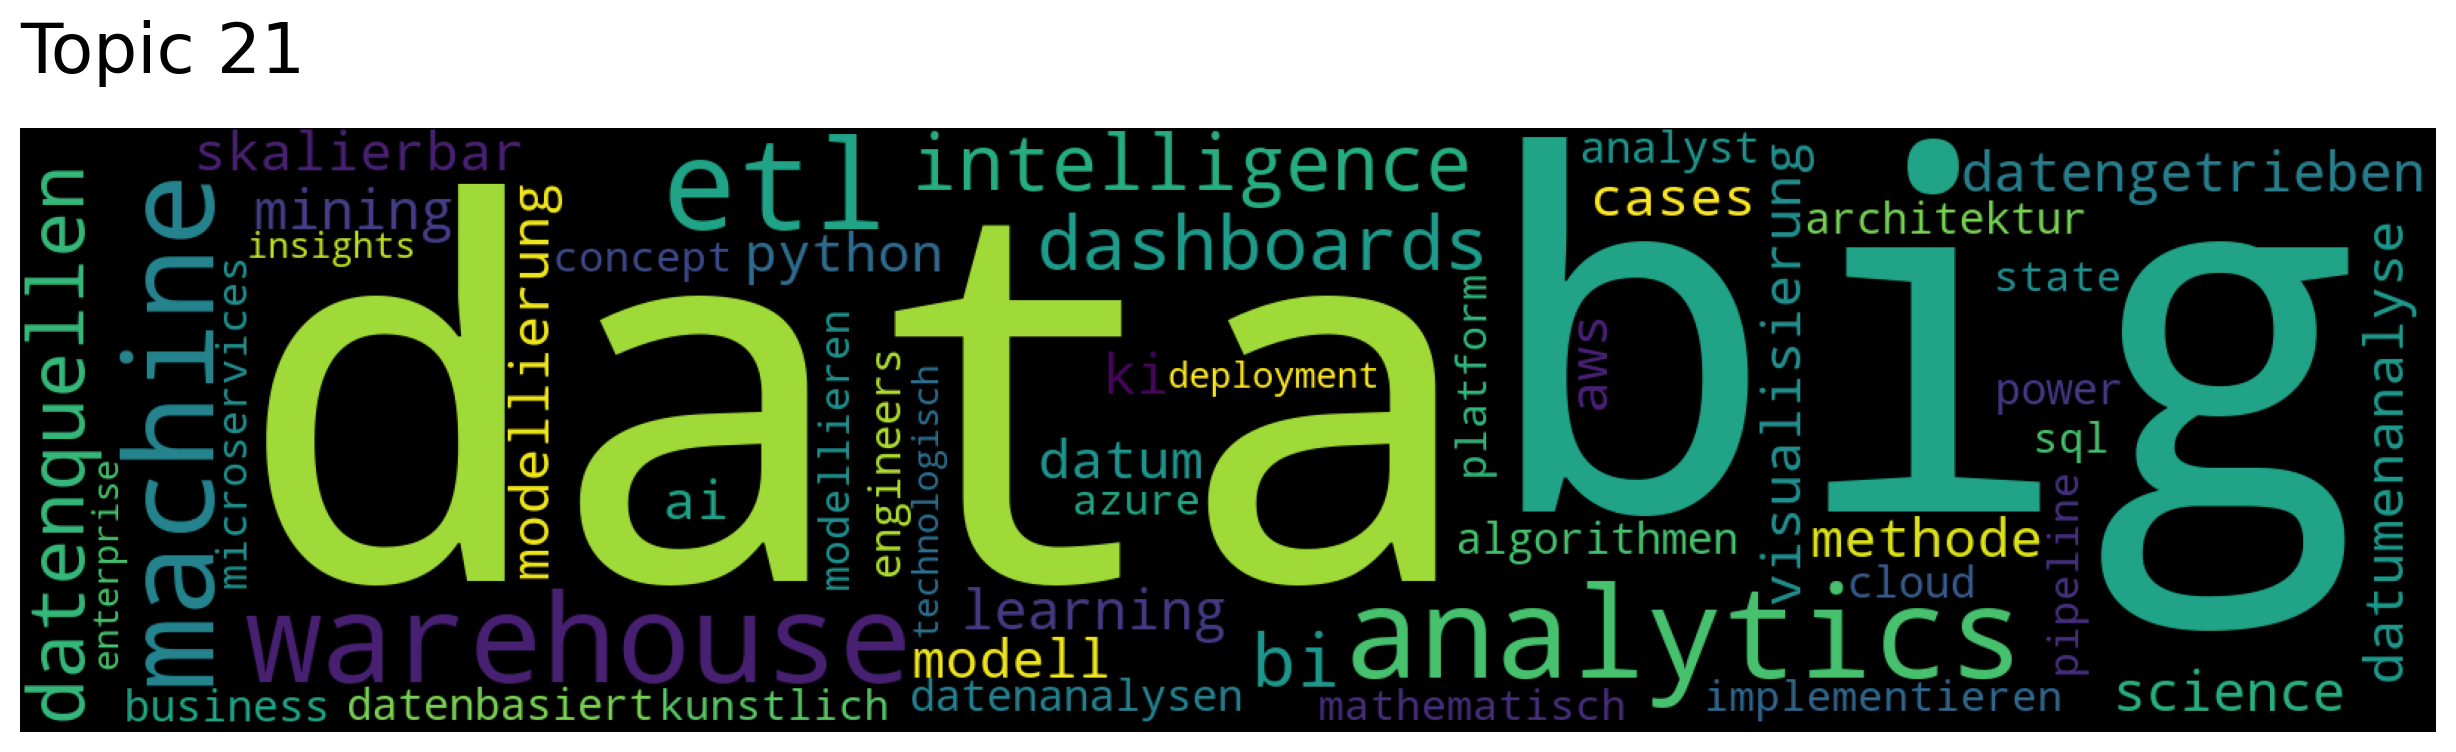

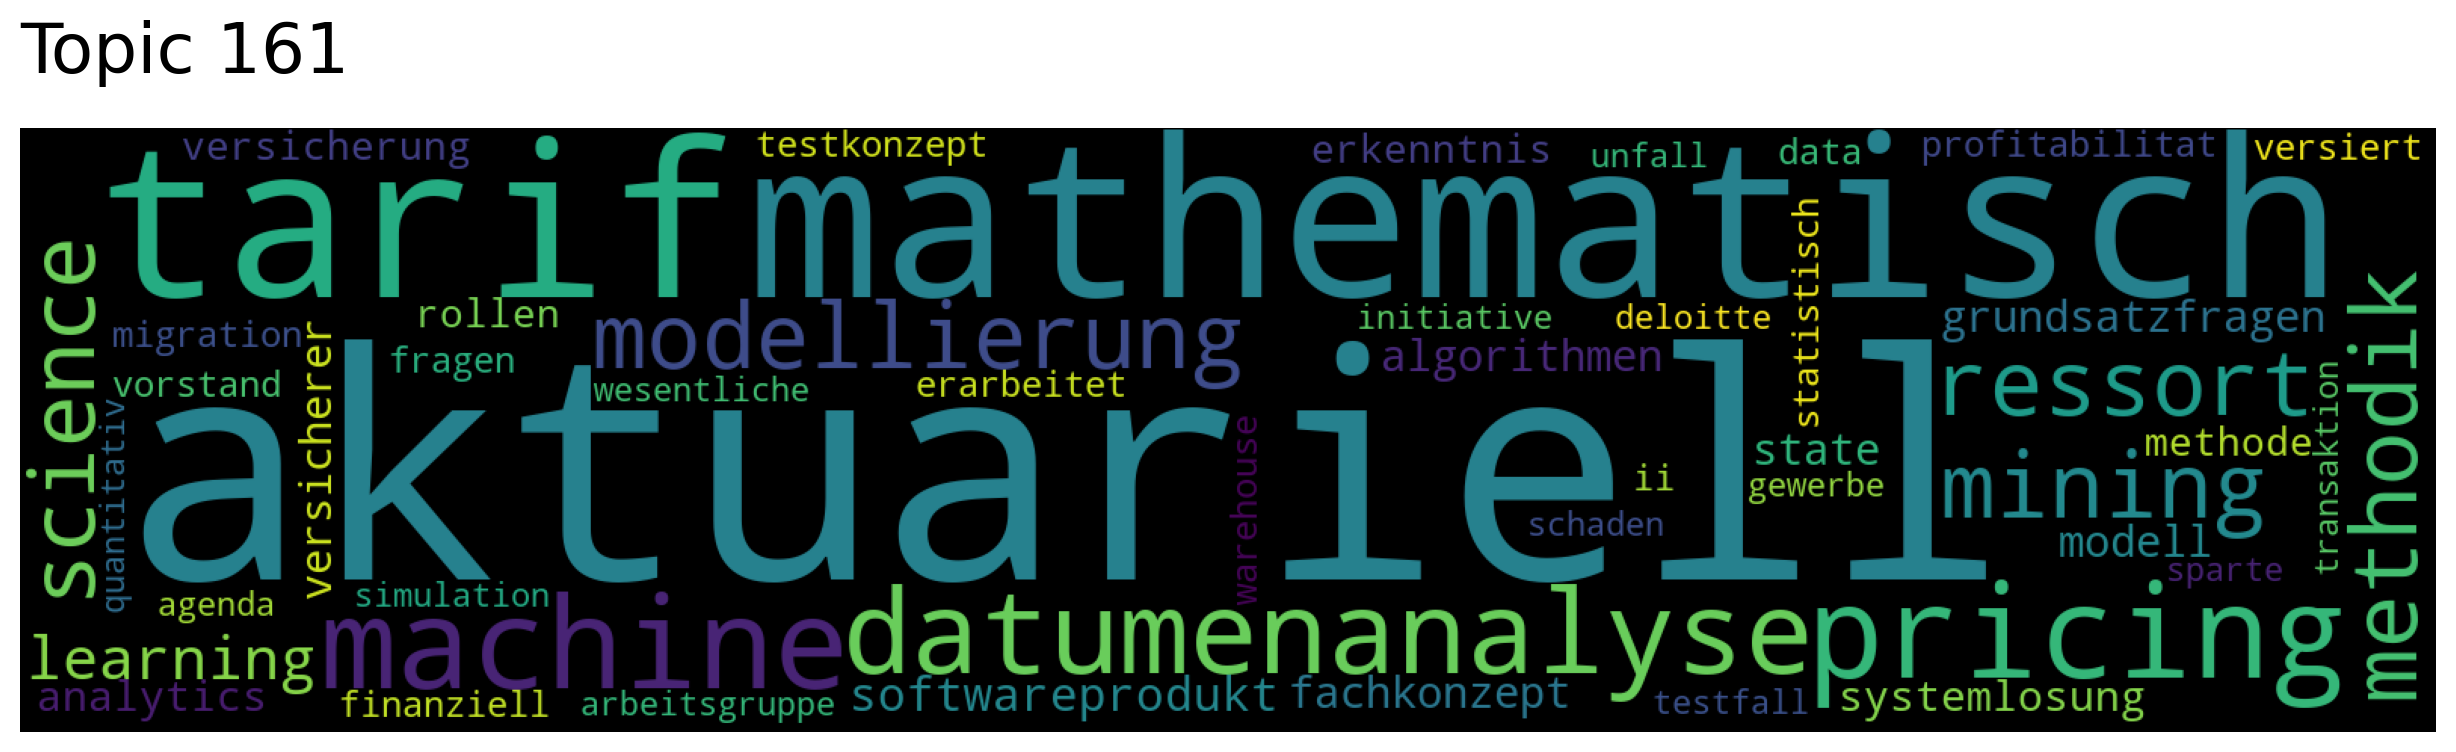

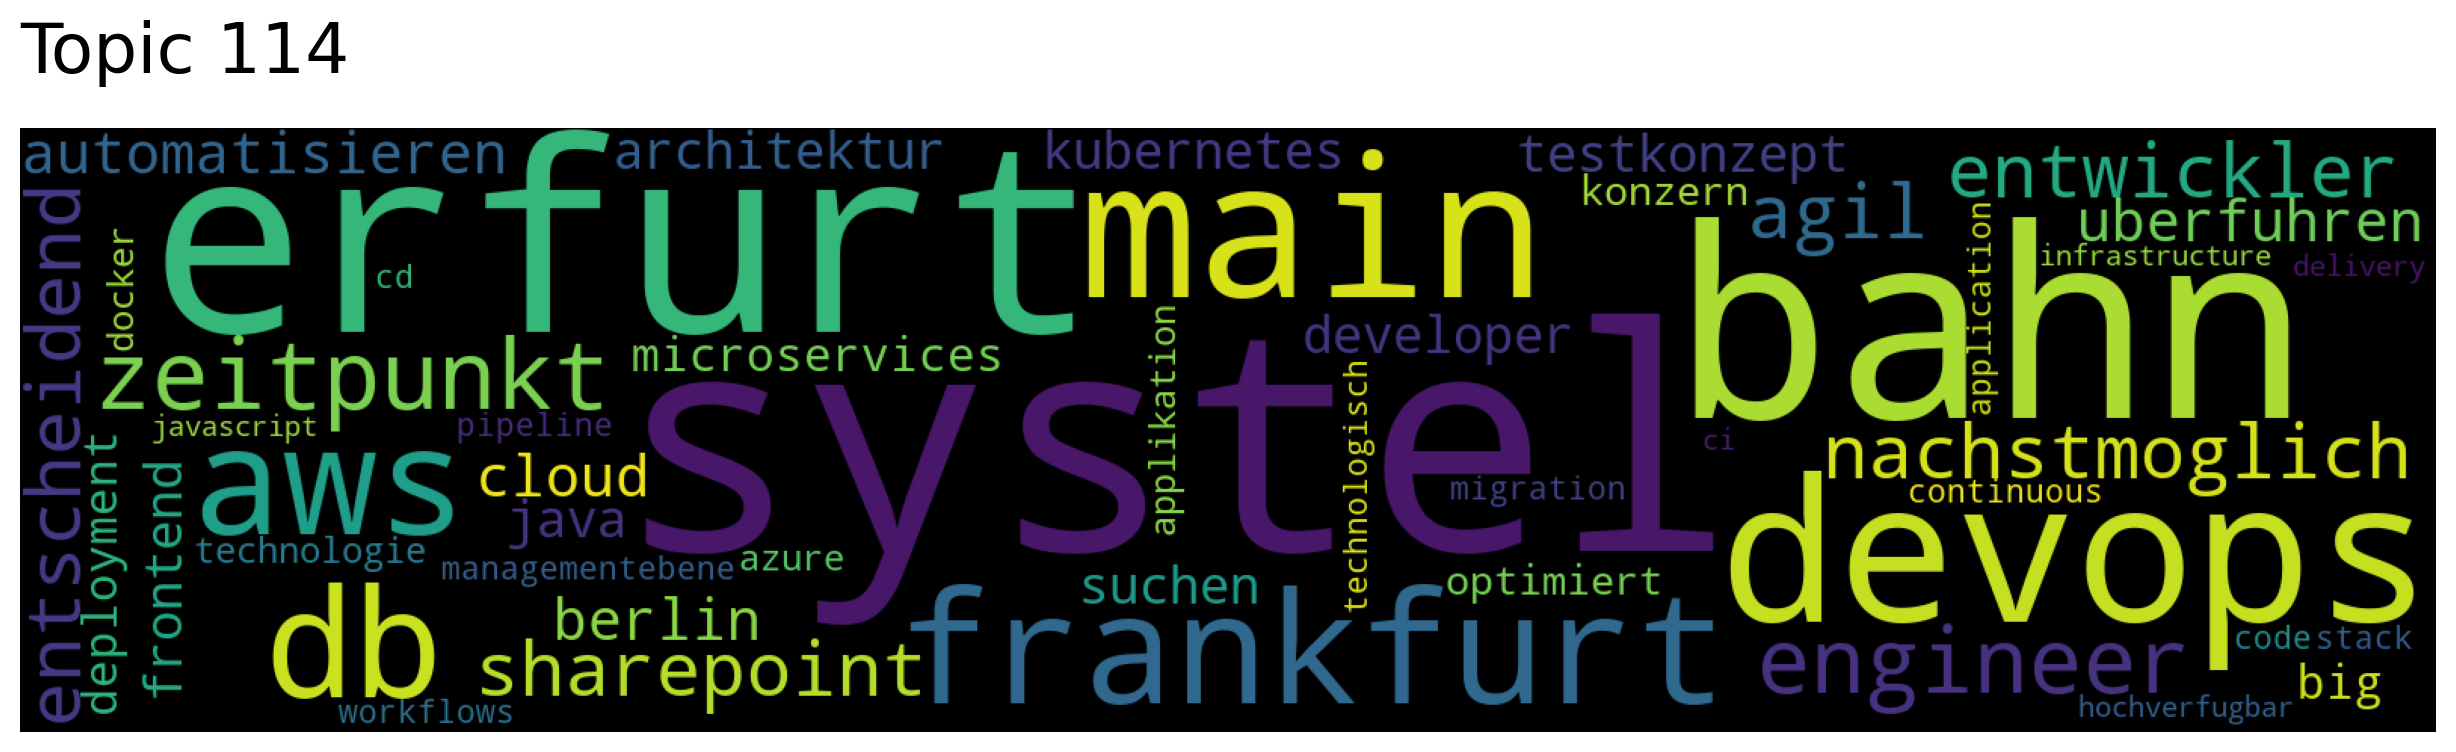

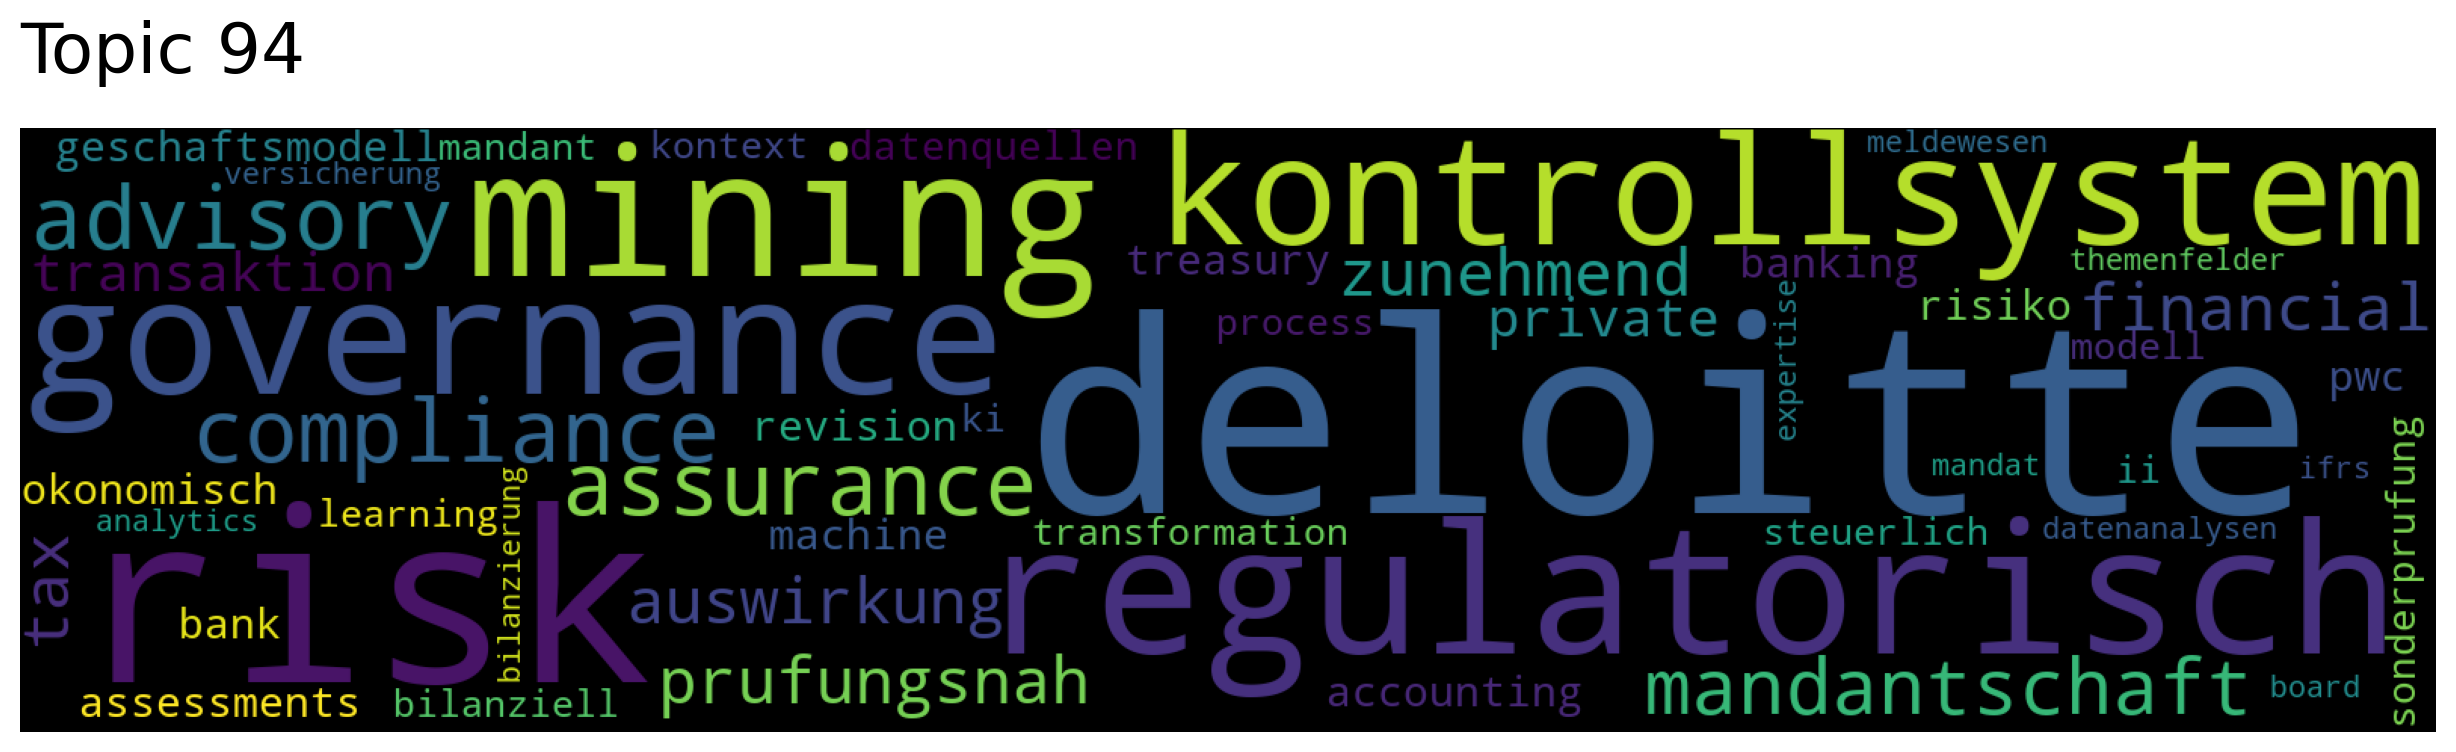

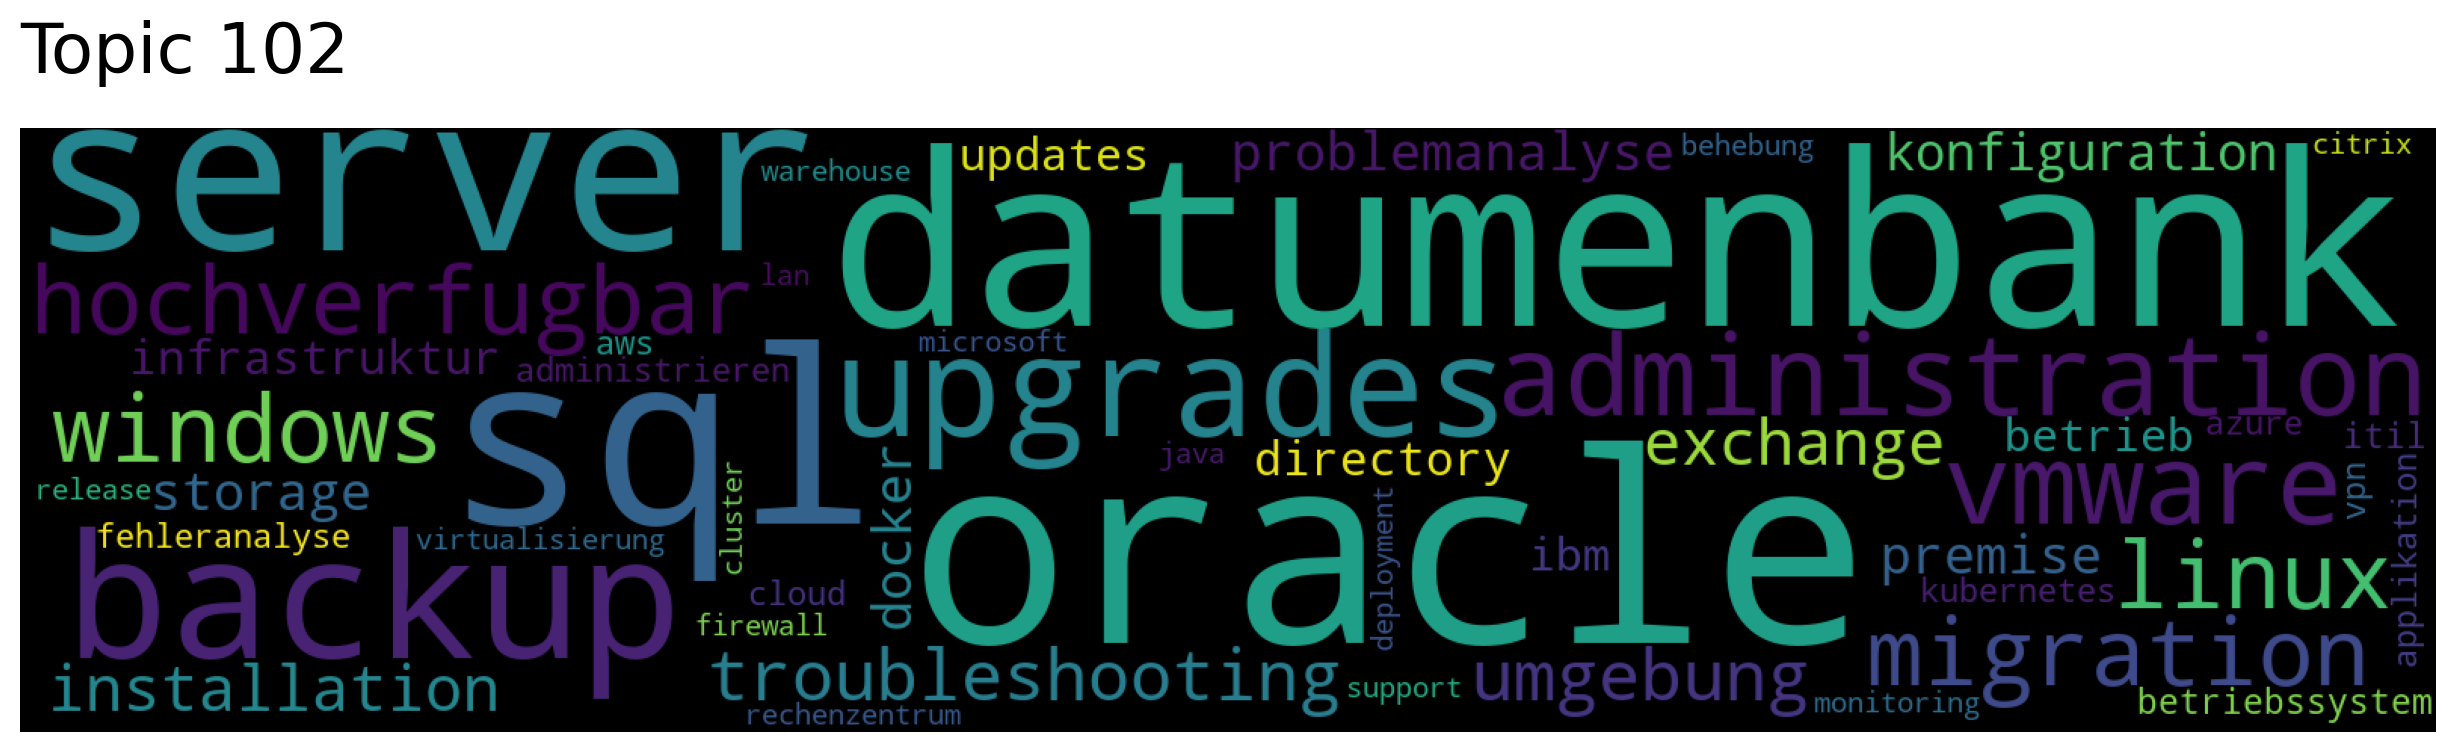

In [85]:
topic_words, word_scores, topic_scores, topic_nums = descriptio_description.search_topics(keywords=["data", "science"], 
                                                                                          num_topics=5)
for topic in topic_nums:
    descriptio_description.generate_topic_wordcloud(topic)

In [86]:
# Search Documents by Topic
documents, document_scores, document_ids = descriptio_description.search_documents_by_keywords(keywords=["data", "science"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 6684, Score: 0.539962887763977
-----------
global abteilung betreuen international digitalisierung projekt dabei analysieren verbessern eng zusammenarbeit fachabteilung geschäftsprozeß fungieren anwendungsberater projektleiter verantworten services steueren extern partner teil team unterstützen strategisch technologisch gestaltung optimierung betrieb unternehmen kernprozeß bereich data science business intelligence arbeiten projekt implementierung data science ki anwendung analysieren visualisiert neu zusammenhang datum konzeptionieren implementieren notwendig algorithmen datengetrieben applikation produkt beteiligen evaluierung pilotierung neu data science ki us cases beraten fachbereich bezüglich data science ki anforderung deren umsetzung
-----------

Document: 6687, Score: 0.5320875644683838
-----------
global abteilung betreuen international digitalisierung projekt dabei analysieren verbessern eng zusammenarbeit fachabteilung geschäftsprozeß fungieren anwendungsberater p

In [87]:
words, word_scores = descriptio_description.similar_words(keywords=["data", "science"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

big 0.6578040222506356
analytics 0.6489086751929496
machine 0.6054299822544138
intelligence 0.5881320495205465
methode 0.5295101113084093
learning 0.4933162665163257
datum 0.4901056512305039
business 0.4811680334208242
mining 0.47026218703554973
dashboards 0.46980880517691415
cases 0.4608168307281702
ki 0.45531751944294957
etl 0.44151900801191063
datenquellen 0.4385227340019849
losung 0.4357866540507025
warehouse 0.4351441147695412
technologie 0.4350930326128585
anwendung 0.42892724261968074
digital 0.42471054163362165
datengetrieben 0.42373926370662185


In [100]:
profile_model = topics(df['lemm_profile'])

2021-07-16 21:29:18,814 - top2vec - INFO - Pre-processing documents for training
2021-07-16 21:29:22,990 - top2vec - INFO - Creating joint document/word embedding
2021-07-16 21:46:05,562 - top2vec - INFO - Creating lower dimension embedding of documents
2021-07-16 21:46:14,640 - top2vec - INFO - Finding dense areas of documents
2021-07-16 21:46:16,790 - top2vec - INFO - Finding topics


In [101]:
profile_model.get_num_topics()

287

In [103]:
topic_sizes, topic_nums = profile_model.get_topic_sizes()

In [104]:
topic_sizes

array([1004,  934,  876,  546,  480,  452,  427,  376,  368,  362,  361,
        352,  347,  318,  294,  292,  278,  276,  275,  273,  271,  258,
        257,  257,  253,  242,  225,  224,  218,  218,  215,  211,  211,
        210,  199,  198,  192,  192,  191,  190,  189,  187,  187,  186,
        186,  185,  184,  183,  181,  179,  175,  173,  173,  173,  173,
        172,  171,  167,  166,  166,  166,  165,  164,  164,  162,  161,
        160,  160,  160,  154,  154,  154,  154,  152,  151,  151,  150,
        149,  149,  149,  148,  147,  146,  146,  144,  144,  144,  144,
        143,  138,  138,  137,  137,  137,  136,  134,  134,  134,  134,
        132,  131,  130,  130,  129,  129,  129,  129,  128,  128,  128,
        127,  126,  125,  125,  125,  124,  123,  122,  122,  122,  120,
        119,  118,  118,  118,  118,  117,  117,  115,  114,  114,  114,
        112,  112,  111,  110,  109,  109,  108,  107,  107,  106,  105,
        105,  104,  104,  103,  103,  103,  103,  1

In [109]:
topic_words, word_scores, topic_scores, topic_nums = profile_model.search_topics(keywords=["data", "science", "statistik"], 
                                                                                 num_topics=5)

In [110]:
topic_words

[array(['data', 'statistik', 'machine', 'intelligence', 'python',
        'tableau', 'mining', 'learning', 'sql', 'mathematik', 'analytics',
        'statistisch', 'bi', 'sas', 'datumenanalyse', 'science', 'etl',
        'big', 'spark', 'warehouse', 'datumenbank', 'relational',
        'modellierung', 'visualisierung', 'datenmengen', 'vba', 'datum',
        'quantitativ', 'informatik', 'power', 'business', 'java', 'modell',
        'ibm', 'aws', 'nosql', 'wirtschaft', 'mathematisch', 'hana', 'bw',
        'kafka', 'gcp', 'oracle', 'azure', 'cloud', 'matlab', 'analyse',
        'process', 'analyst', 'devops'], dtype='<U15'),
 array(['pharmazeutisch', 'gmp', 'pharmazie', 'biotechnologie', 'chemie',
        'biologie', 'reguliert', 'pharma', 'herstellung', 'validierung',
        'regularium', 'industrie', 'regulatorisch', 'chemisch', 'affairs',
        'bta', 'cta', 'promotion', 'medizin', 'medizinprodukt', 'labor',
        'chemielaborant', 'medizintechnik', 'mta', 'approbation',
       

In [111]:
# Semantic Search Documents by Keywords
documents, document_scores, document_ids = profile_model.search_documents_by_keywords(keywords=["data", "science", "statistik", "cloud"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 8856, Score: 0.527877151966095
-----------
erfolgreich studium informatik wirtschaftsinformatik mathematik ingenieurwissenschaft naturwissenschaft master bachelor berufspraxis erster erfahrung objektorientiert funktional programmierung wünschenswert praktisch know data lake implementierung googeln cloud plattform alternativ erster erfahrung hadoop distribution cloudera hortonworks impala hiv programmierung scala spark python anwendung big data applikationen umfeld machine learning data science artificial intelligence kommunikationsgeschick teamgeist ausgeprägt analyse konzeptionsstärke hoch lernbereitschaft
-----------

Document: 34475, Score: 0.5197080373764038
-----------
gut fach hochschulabschluss statistik mathematik informatik vergleichbar fundiert fachkenntnisse bereich statistik informatik linguistik natural language processing sicher umgang methode datenaufbereitung visualisierung analyse insbesondere bereich machine learning z na bayes regression neuronal netz deep 

In [112]:
import pickle

In [113]:
# save the model to disk
filename_title = 'model_title_top2vec.pickle'
pickle.dump(title_model, open(filename_title, 'wb'))

filename_description = 'model_description_top2vec.pickle'
pickle.dump(descriptio_description, open(filename_description, 'wb'))

filename_profile = 'model_profile_top2vec.pickle'
pickle.dump(profile_model, open(filename_profile, 'wb'))

# Word Frequency 

In [49]:
from bokeh.models import NumeralTickFormatter

In [92]:
# Word Frequency of most common words title
texts = list(map(lambda t: ' '.join(t), df['lemm_title'])) #merging word lists (lemmas)
word_freq = pd.Series(" ".join(texts).split()).value_counts()
#word_freq[1:40].rename("Word frequency of most common words").hvplot.bar(
    #rot=45
#).opts(width=700, height=400, yformatter=NumeralTickFormatter(format="0,0"))
word_freq[1:10]

In [20]:
texts_description = list(map(lambda t: ' '.join(t), df['lemm_job_description'])) 
word_freq_description = pd.Series(" ".join(texts_description).split()).value_counts()
word_freq_description[1:20]

kunde                14971
erstellung           11565
team                 11364
bereich              10434
projekt              10412
durchführung          9907
unterstützung         9897
neu                   8828
aufgabe               8605
entwicklung           8300
technisch             8097
umsetzung             7229
unterstützen          7016
intern                6980
prozeß                6745
betreuung             6667
weiterentwicklung     6653
zusammenarbeit        6623
planung               6326
dtype: int64

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

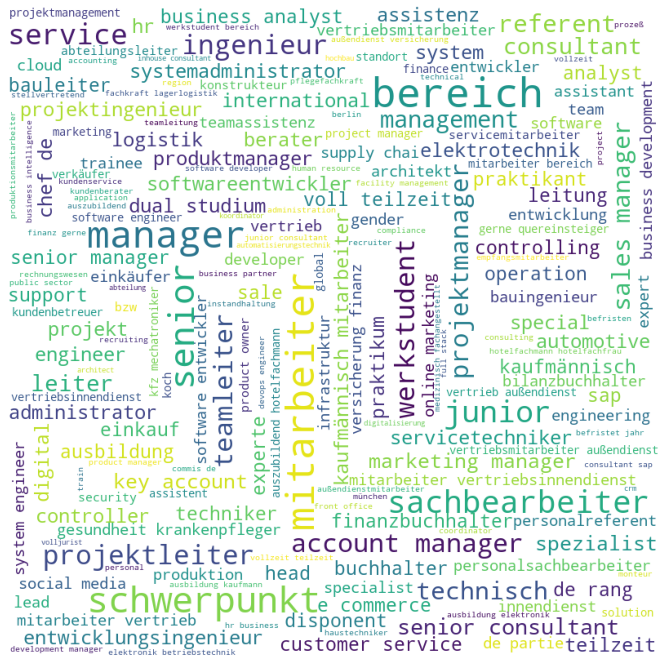

In [22]:
text = " ".join(texts)
wordcloud = WordCloud(
    width = 800,
    height = 800,
    #stopwords = ['Schwerpunkt', 'Bereich', 'Mitarbeiter', 'Sachbearbeiter'], 
    background_color = "white", 
    max_font_size = 50
).generate(text)
plt.figure(figsize = (16,12))#plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

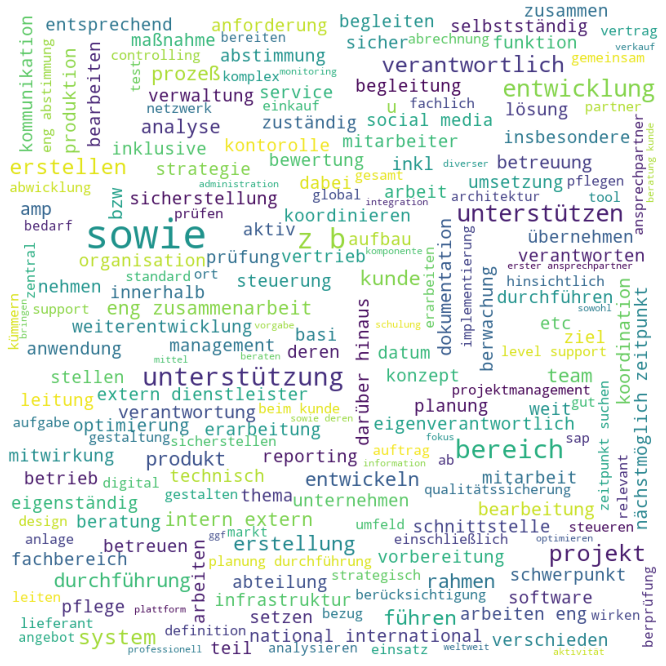

In [23]:
text_description = " ".join(texts_description)
wordcloud = WordCloud(
    width = 800,
    height = 800, 
    background_color = "white", 
    max_font_size = 50
).generate(text_description)
plt.figure(figsize = (16,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# TF-IDF

*tf(w,d)*: the ratio of the number of appearances of w in d divided with the total number of words in d.

*idf(w)*: the logarithm of the fraction of the total number of documents divided by the number of documents that contain w.

**tfidf(w,d)=tf(w,d) x idf(w)*

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
vectorizer_title = TfidfVectorizer(
    analyzer="word", ngram_range=(2, 3), norm="l2")
X = vectorizer_title.fit(texts)

In [67]:
print(X)

TfidfVectorizer(ngram_range=(3, 4))


In [42]:
# Vector representation of vocabulary
word_vector = pd.Series(vectorizer_title.vocabulary_).sample(20, random_state=1)
print(f" word (ngram) vector extract:\n\n{word_vector}")

 word (ngram) vector extract:

anlagenelektroniker brandmelde löschanlagen     3022
software entwickler business                   78943
referent global account                        68879
entwicklung dosiertechnik                      26106
chang problem koordinator                      15413
gerne minijob                                  32535
zahnmed fachangestellt                         95688
creative director text                         18729
event bau                                      27195
channel planning consultant                    15430
pressesprecher senior                          61897
freizeitorientiert jugendarbeit teil           31204
steuerberatung deloitte private                82224
portfoliomanager strom                         60932
service süddeutschland                         77392
gruppenleiter bau                              33794
assistenz schwerpunkt china                     5401
ans meer                                        3191
cloud storage  

In [81]:
lem_titles = df['lemm_title']
#lem_titles[lem_titles.is(lem_titles == 'ür')]
df[lem_titles.apply(lambda x: np.in1d('ür', x)[0])].title[34172]

'Personalreferent (w/m/*) für unser neues Verkehrsnetz "Dieselnetz Niedersachsen-Mitte"'

In [45]:
vectorizer_job_descript = TfidfVectorizer(
    analyzer="word", ngram_range=(3, 4), norm="l2"
)
vectorizer_job_descript.fit(texts_description)

job_description_vector = pd.Series(vectorizer_job_descript.vocabulary_).head(20)
print(f" word (ngram) vector extract:\n\n{job_description_vector}")

 word (ngram) vector extract:

botengänge fahrt erledigung                 482872
fahrt erledigung einkauf                    903073
erledigung einkauf betreuung                812367
einkauf betreuung alt                       702723
betreuung alt kind                          435932
alt kind kochen                              77293
kind kochen housekeeping                   1288905
kochen housekeeping wäsche                 1298080
housekeeping wäsche service                1139926
wäsche service abendessen                  2716859
service abendessen haustierbetreuung       2098578
abendessen haustierbetreuung telefonat        4376
haustierbetreuung telefonat recherche      1107114
telefonat recherche tischreservierung      2374013
recherche tischreservierung einbringung    1964537
tischreservierung einbringung kompetenz    2403931
einbringung kompetenz flach                 690038
kompetenz flach hierarchie                 1315742
botengänge fahrt erledigung einkauf         482873


# K-means clustering

In [114]:
vectorized = vectorizer.fit_transform(texts)

In [72]:
print(vectorized.shape)

(37859, 70778)


In [51]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

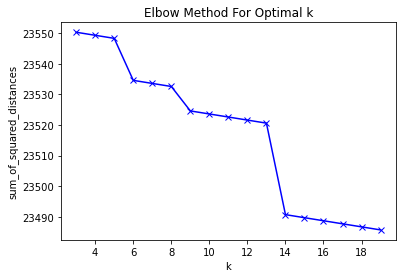

In [85]:
sum_of_squared_distances = []
K = range(3, 20)

for k in K:
    km = KMeans(init="random", n_clusters = k, max_iter = 300, n_init = 20, random_state=42)
    km = km.fit(vectorized)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [91]:
true_k = 9
model = KMeans(n_clusters=true_k, init='random', max_iter=300, n_init=10)
model.fit(vectorized)
labels=model.labels_
title_cl=pd.DataFrame(list(zip(texts, labels)),columns=['title','cluster'])
print(title_cl.sort_values(by=['cluster']))

                                           title  cluster
2463                  Account Manager Automotive        0
27724             Key Account Manager automotive        0
26461  Key Account Manager automotive e mobility        0
9946       Senior Key Account Manager Automotive        0
4742              Key Account Manager Automotive        0
...                                          ...      ...
36785                       Junior Sales Manager        8
23466                       Junior Sales Manager        8
3663                        Junior Sales Manager        8
23520                       Junior Sales Manager        8
33233                       Junior Sales Manager        8

[37859 rows x 2 columns]


In [87]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(vectorized)
  labels = kmeans.labels_
  sil.append(silhouette_score(vectorized, labels, metric = 'euclidean'))

In [92]:
#we can say that the clusters are well apart from each other if the silhouette score is closer to 1

[0.21017947182408767,
 0.21064483206625212,
 0.21159978764851567,
 0.21364720447544366,
 0.21323794530107848,
 0.21439224227016496,
 0.21383505832067567,
 0.21627829714092706,
 0.21466257695114088]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['Economy..GDP.per.Capita.'],wh1['Trust..Government.Corruption.'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
plt.colorbar(scatter)

# FlairNLP
https://github.com/flairNLP/flair

In [51]:
import torch

torch.cuda.is_available()

True

In [52]:
import flair, torch

device = None
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

flair.device = device

In [64]:
#import importlib
#importlib.reload(sent_tok)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2021-07-08 17:54:23,405 loading file C:\Users\bb1\.flair\models\de-pos-ud-hdt-v0.5.pt
2021-07-08 17:54:23,653 --------------------------------------------------------------------------------
2021-07-08 17:54:23,654 The model key 'pos' now maps to 'https://huggingface.co/flair/pos-english' on the HuggingFace ModelHub
2021-07-08 17:54:23,655  - The most current version of the model is automatically downloaded from there.
2021-07-08 17:54:23,656  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/pos/en-pos-ontonotes-v0.5.pt)
2021-07-08 17:54:23,656 --------------------------------------------------------------------------------
2021-07-08 17:54:24,112 loading file C:\Users\bb1\.flair\models\pos-english\a9a73f6cd878edce8a0fa518db76f441f1cc49c2525b2b4557af278ec2f0659e.121306ea62993d04cd1978398b68396931a39eb47754c8a06a87f325ea70ac63


<module 'sent_tok' from 'D:\\Code\\datascience\\job-market-covid19-analysis\\src\\sent_tok.py'>

In [49]:
#from multiprocessing import cpu_count, Pool
#import sent_tok

In [ ]:
#from multiprocessing import cpu_count, Pool
#import sent_tok

#if __name__ ==  '__main__': 
#    pool = Pool(cpu_count() - 1)
#    df['lemm_introduction'] = pool.map(lemma.lemma_text, df['clean_introduction'])
#    print(df['lemm_introduction'].head(20))

In [53]:
from flair.embeddings import WordEmbeddings

from flair.embeddings import FlairEmbeddings
from flair.embeddings import WordEmbeddings, FlairEmbeddings
from flair.embeddings import StackedEmbeddings
from flair.models import SequenceTagger
from flair.models import MultiTagger
from flair.tokenization import SegtokSentenceSplitter
from flair.data import Sentence

from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings
from flair.embeddings import StackedEmbeddings

# init Flair embeddings
flair_forward_embedding = FlairEmbeddings('multi-forward')
flair_backward_embedding = FlairEmbeddings('multi-backward')

# init multilingual BERT
#bert_embedding = TransformerWordEmbeddings('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [83]:
# now create the StackedEmbedding object that combines all embeddings
stacked_embeddings = StackedEmbeddings(
    embeddings=[flair_forward_embedding, flair_backward_embedding])

# load tagger
tagger = MultiTagger.load(['de-ner-large', 'ner-large'])
splitter = SegtokSentenceSplitter()

count = 0

def sent_tok (text):
    global count
    
    new_text_array = []
    sentences = splitter.split(text)
    
    tags = tagger.predict(sentences)

    for sent in sentences:
        embeddings = stacked_embeddings.embed(sent)
        for token in sent:
            new_text_array.append(token.embedding)

        #print(sent.to_tagged_string())
        #print(sent)
    count += 1
    if count % 100 == 0:
        print(count)
    return new_text_array

2021-07-08 21:00:15,602 --------------------------------------------------------------------------------
2021-07-08 21:00:15,603 The model key 'de-ner-large' now maps to 'https://huggingface.co/flair/ner-german-large' on the HuggingFace ModelHub
2021-07-08 21:00:15,603  - The most current version of the model is automatically downloaded from there.
2021-07-08 21:00:15,603 --------------------------------------------------------------------------------
2021-07-08 21:00:16,110 loading file C:\Users\bb1\.flair\models\ner-german-large\6b8de9edd73722050be2547acf64c037b2df833c6e8f0e88934de08385e26c1e.4b0797effcc6ebb1889d5d29784b97f0a099c1569b319d87d7c387e44e2bba48
2021-07-08 21:00:23,893 --------------------------------------------------------------------------------
2021-07-08 21:00:23,894 The model key 'ner-large' now maps to 'https://huggingface.co/flair/ner-english-large' on the HuggingFace ModelHub
2021-07-08 21:00:23,894  - The most current version of the model is automatically downloa

In [65]:
#sent_tok.sent_tok(df['clean_title'][1])

Teamleiter <NN/NNP> für <APPR/NN> unsere <PPOSAT/NN> Triebfahrzeugführer <NN/NNP> im <APPRART/NNP> Güterfernverkehr <NN/NNP>


[tensor([ 2.3191e-01,  4.4622e-02,  1.3398e-03,  ...,  1.8837e+00,
          2.8848e-01, -5.1646e-01]),
 tensor([ 0.3259,  0.0250,  0.0007,  ..., -0.2914, -0.0773,  0.5350]),
 tensor([ 0.1188, -0.0011,  0.0003,  ..., -0.0797, -0.1102, -0.0633]),
 tensor([ 9.1056e-02,  2.8929e-02,  3.7013e-04,  ...,  6.9811e-01,
         -3.8550e-01, -6.2824e-01]),
 tensor([-0.4714,  0.0459,  0.0030,  ...,  0.3348, -0.4205,  0.3579]),
 tensor([-0.0659,  0.0185,  0.0016,  ...,  1.2117,  0.5248, -0.1468])]

In [84]:
sent_tok(df['clean_title'][1])

[tensor([-0.7086,  0.0192,  0.0013,  ..., -0.0821,  0.0946, -0.7250],
        device='cuda:0'),
 tensor([-9.5411e-02,  1.1840e-04,  1.7885e-03,  ...,  3.7502e-01,
          7.2424e-01, -2.0529e-02], device='cuda:0'),
 tensor([ 3.1435e-01,  4.6515e-04,  6.5687e-04,  ...,  1.3815e+00,
         -3.7334e-01,  1.1413e-01], device='cuda:0'),
 tensor([ 0.0718,  0.0046,  0.0032,  ...,  0.7386,  0.0745, -0.2858],
        device='cuda:0'),
 tensor([ 0.2515,  0.0203,  0.0045,  ...,  0.6676, -0.4349,  0.5317],
        device='cuda:0'),
 tensor([ 1.7273e-02, -6.5823e-03,  1.4921e-04,  ...,  2.5627e-01,
          1.5311e-01, -4.7867e-01], device='cuda:0'),
 tensor([ 1.8858e-01, -1.8225e-03,  6.8731e-04,  ...,  8.1202e-01,
          3.3537e-01,  1.6361e-01], device='cuda:0'),
 tensor([-0.0911,  0.0077,  0.0016,  ...,  1.0411,  0.2907,  0.0794],
        device='cuda:0'),
 tensor([ 4.8017e-02,  9.5320e-03,  2.6573e-04,  ...,  1.1371e+00,
          3.4174e-02, -6.2496e-01], device='cuda:0'),
 tensor([-5

In [85]:
df['emb_title'] = df['clean_title'].apply(sent_tok)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 24.00 GiB total capacity; 21.06 GiB already allocated; 0 bytes free; 21.88 GiB reserved in total by PyTorch)

In [ ]:
if __name__ ==  '__main__': 
    pool = Pool(cpu_count() - 1)
    df['embeddings_title'] = pool.map(sent_tok.sent_tok, df['clean_title'])
    print(df['embeddings_title'][1])